# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.svm import SVC

from typing import Tuple, Dict, Union


# Drive mounting

In [2]:
! ls

churn_predictions.ipynb  queries.csv	   test_predictions.csv
dataset.csv		 requirements.txt


# Data loading

Dataset entries are described [here](https://www.kaggle.com/datasets/blastchar/telco-customer-churn).

In [3]:
dataset = pd.read_csv('./dataset.csv')
display(dataset.head(5))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0.0,Yes,Yes,72.0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),25.20,1787.35,0
1,Male,0.0,No,No,40.0,Yes,No,Fiber optic,No,Yes,No,Yes,No,Yes,One year,Yes,Credit card (automatic),89.60,3488.15,0
2,Male,0.0,Yes,Yes,40.0,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Mailed check,60.30,2448.5,0
3,Male,0.0,Yes,Yes,58.0,Yes,Yes,Fiber optic,No,No,Yes,Yes,No,Yes,Two year,No,Bank transfer (automatic),94.35,5563.65,0
4,Male,0.0,Yes,Yes,44.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.00,860.85,0


In [4]:
query = pd.read_csv('./queries.csv')
display(query.head(5))

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Male,0.0,No,No,45.0,No,No phone service,DSL,Yes,NaN,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
1,Male,0.0,Yes,Yes,13.0,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45
2,Male,0.0,No,Yes,71.0,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,Two year,No,Bank transfer (automatic),106.70,7382.25
3,Female,0.0,No,No,30.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),55.30,1530.6
4,Female,1.0,Yes,No,71.0,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,No,No,Two year,Yes,Credit card (automatic),96.35,6766.95


# Pre-processing

## Code

In [5]:
def preprocess_data(dataset_df, query_df=None):
    # Handle TotalCharges column
    if 'TotalCharges' in dataset_df.columns:
        dataset_df['TotalCharges'] = pd.to_numeric(dataset_df['TotalCharges'], errors='coerce')
    if query_df is not None and 'TotalCharges' in query_df.columns:
        query_df['TotalCharges'] = pd.to_numeric(query_df['TotalCharges'], errors='coerce')

    # Identify target column
    target_col = 'Churn'
    has_target_dataset = target_col in dataset_df.columns
    has_target_query = query_df is not None and target_col in query_df.columns

    # Separate features and target
    dataset_features_df = dataset_df.drop(target_col, axis=1) if has_target_dataset else dataset_df.copy()
    churn_df = dataset_df[target_col].copy() if has_target_dataset else None

    if query_df is not None:
        query_features_df = query_df.drop(target_col, axis=1) if has_target_query else query_df.copy()

    # Identify column types
    numerical_columns = []
    categorical_columns = []

    for col in dataset_features_df.columns:
        if col == 'SeniorCitizen':
            # Explicitly treat SeniorCitizen as categorical
            categorical_columns.append(col)
        elif dataset_features_df[col].dtype in ['int64', 'float64']:
            # Check if it's actually categorical (like binary 0/1)
            unique_vals = dataset_features_df[col].dropna().unique()
            if len(unique_vals) <= 10 and all(isinstance(x, (int, float)) and x.is_integer() for x in unique_vals):
                categorical_columns.append(col)
            else:
                numerical_columns.append(col)
        else:
            categorical_columns.append(col)

    print(f"Numerical columns: {numerical_columns}")
    print(f"Categorical columns: {categorical_columns}")

    # Identify binary vs multi-categorical
    binary_categorical = []
    multi_categorical = []

    for col in categorical_columns:
        unique_vals = dataset_features_df[col].dropna().unique()
        if len(unique_vals) <= 2:
            binary_categorical.append(col)
        else:
            multi_categorical.append(col)

    print(f"Binary categorical: {binary_categorical}")
    print(f"Multi-categorical: {multi_categorical}")

    # Initialize processed dataframes
    dataset_processed_df = dataset_features_df.copy()
    if query_df is not None:
        query_processed_df = query_features_df.copy()

    # 1. Impute missing values
    # Numerical imputation
    if numerical_columns:
        num_imputer = SimpleImputer(strategy='mean')
        dataset_processed_df[numerical_columns] = num_imputer.fit_transform(dataset_processed_df[numerical_columns])

        if query_df is not None:
            query_processed_df[numerical_columns] = num_imputer.transform(query_processed_df[numerical_columns])

    # Categorical imputation
    if categorical_columns:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        dataset_processed_df[categorical_columns] = cat_imputer.fit_transform(dataset_processed_df[categorical_columns])

        if query_df is not None:
            query_processed_df[categorical_columns] = cat_imputer.transform(query_processed_df[categorical_columns])

    # 2. Label encoding for binary categorical columns
    label_encoders = {}
    for col in binary_categorical:
        le = LabelEncoder()
        dataset_processed_df[col] = le.fit_transform(dataset_processed_df[col])
        label_encoders[col] = le

        if query_df is not None:
            query_processed_df[col] = le.transform(query_processed_df[col])

    # 3. One-hot encoding for multi-categorical columns
    if multi_categorical:
        onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        # Fit and transform dataset
        onehot_dataset_df = onehot_encoder.fit_transform(dataset_processed_df[multi_categorical])

        # Create column names for one-hot encoded features
        onehot_columns = []
        for i, col in enumerate(multi_categorical):
            categories = onehot_encoder.categories_[i]
            for cat in categories:
                onehot_columns.append(f"{col}_{cat}")

        # Create DataFrame for one-hot encoded features
        onehot_dataset_features_df = pd.DataFrame(onehot_dataset_df, columns=onehot_columns, index=dataset_processed_df.index)

        # Drop original columns and add one-hot encoded columns
        dataset_processed_df = dataset_processed_df.drop(multi_categorical, axis=1)
        dataset_processed_df = pd.concat([dataset_processed_df, onehot_dataset_features_df], axis=1)

        # Transform query data if provided
        if query_df is not None:
            onehot_query_df = onehot_encoder.transform(query_processed_df[multi_categorical])
            onehot_query_features_df = pd.DataFrame(onehot_query_df, columns=onehot_columns, index=query_processed_df.index)

            query_processed_df = query_processed_df.drop(multi_categorical, axis=1)
            query_processed_df = pd.concat([query_processed_df, onehot_query_features_df], axis=1)

    print(f"Dataset processed shape: {dataset_processed_df.shape}")
    if query_df is not None:
        print(f"Query data processed shape: {query_processed_df.shape}")

    # Return appropriate result
    if query_df is None:
        return dataset_processed_df, churn_df
    else:
        return dataset_processed_df, churn_df, query_processed_df

In [6]:
dataset_processed_df, churn_df, query_processed_df = preprocess_data(dataset, query)

display(dataset_processed_df.head(5))
display(churn_df.head(5))
display(query_processed_df.head(5))

Numerical columns: ['tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Binary categorical: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
Multi-categorical: ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Dataset processed shape: (5634, 40)
Query data processed shape: (1409, 40)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,1,72.0,1,0,25.20,1787.35,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,1,0,0,0,40.0,1,1,89.60,3488.15,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,1,1,40.0,0,0,60.30,2448.50,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,1,0,1,1,58.0,1,0,94.35,5563.65,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1,0,1,1,44.0,1,0,20.00,860.85,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


0    0
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,MultipleLines_No,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,0,45.0,0,0,42.30,1840.75,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,1,0,1,1,13.0,1,1,49.95,587.45,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,1,71.0,1,0,106.70,7382.25,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0,0,0,0,30.0,1,1,55.30,1530.60,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,1,1,0,71.0,1,1,96.35,6766.95,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Report

Write down what you tried in this section. Include your observations, hypothesis, things you are not sure about, ideas for experiments that could be worth trying. You are encouraged to use graphs/tables/pieces of code. You can create new code and text cells. Take a look [here](https://www.markdownguide.org/cheat-sheet/) to improve the quality of your report.

Things to consider in this section:
- NaN values removal
- Non-numeric data coding

# Visualization

## Code

In [7]:
def analyze_and_visualize_data(dataset_df, churn_df=None, query_df=None, figsize=(20, 15)):
    results = {}

    # Determine if we have target variable
    has_churn_dataset = churn_df is not None
    query_features_df = query_df.copy() if query_df is not None else None

    # 1. Basic Dataset Statistics
    print("  BASIC DATASET STATISTICS  ")
    print(f"Dataset shape: {dataset_df.shape}")
    if query_df is not None:
        print(f"Query data shape: {query_df.shape}")

    print(f"\nDataset missing values:")
    missing_dataset = dataset_df.isnull().sum()
    print(missing_dataset[missing_dataset > 0] if missing_dataset.sum() > 0 else "No missing values")

    if query_df is not None:
        print(f"\nQuery data missing values:")
        missing_query = query_features_df.isnull().sum()
        print(missing_query[missing_query > 0] if missing_query.sum() > 0 else "No missing values")

    results['dataset_shape'] = dataset_df.shape
    results['missing_values_dataset'] = missing_dataset.to_dict()

    # 2. Churn Distribution Analysis
    if has_churn_dataset:
        print("\n  CHURN DISTRIBUTION ANALYSIS  ")
        churn_counts = churn_df.value_counts()
        churn_props = churn_df.value_counts(normalize=True)

        print("Dataset Churn Distribution:")
        print(f"No Churn (0): {churn_counts.get(0, 0)} ({churn_props.get(0, 0):.2%})")
        print(f"Churn (1): {churn_counts.get(1, 0)} ({churn_props.get(1, 0):.2%})")

        results['churn_distribution_dataset'] = churn_counts.to_dict()

    # 3. Feature Correlation Analysis
    print("\n  CORRELATION ANALYSIS  ")

    # Create correlation matrix
    corr_matrix = dataset_df.corr()

    # Find highly correlated features
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_val = corr_matrix.iloc[i, j]
            if abs(corr_val) > 0.7:  # High correlation threshold
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))

    if high_corr_pairs:
        print("Highly correlated feature pairs (|correlation| > 0.7):")
        for feat1, feat2, corr_val in high_corr_pairs[:10]:  # Show top 10
            print(f"  {feat1} - {feat2}: {corr_val:.3f}")
    else:
        print("No highly correlated feature pairs found")

    results['high_correlations'] = high_corr_pairs

    # 4. Feature Importance Analysis (if target available)
    if has_churn_dataset:
        print("\n  FEATURE IMPORTANCE ANALYSIS  ")

        # Random Forest Feature Importance
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        rf.fit(dataset_df, churn_df)

        feature_importance = pd.DataFrame({
            'feature': dataset_df.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)

        print("Top 10 Most Important Features (Random Forest):")
        print(feature_importance.head(10))

        results['feature_importance'] = feature_importance.to_dict('records')

        # Mutual Information
        mi_scores = mutual_info_classif(dataset_df, churn_df, random_state=42)
        mutual_info_df = pd.DataFrame({
            'feature': dataset_df.columns,
            'mutual_info': mi_scores
        }).sort_values('mutual_info', ascending=False)

        print("\nTop 10 Features by Mutual Information:")
        print(mutual_info_df.head(10))

        results['mutual_information'] = mutual_info_df.to_dict('records')

    # 5. Visualizations
    print("\n  GENERATING VISUALIZATIONS  ")

    # Categorize features
    numerical_features = []
    categorical_features = []
    binary_features = []

    for col in dataset_df.columns:
        unique_vals = dataset_df[col].unique()
        unique_count = len(unique_vals)

        if unique_count == 2 and all(val in [0, 1] for val in unique_vals):
            binary_features.append(col)
        elif unique_count <= 10 or dataset_df[col].dtype == 'object':
            categorical_features.append(col)
        else:
            numerical_features.append(col)

    # Main analysis plots
    n_plots = 4 if has_churn_dataset else 3
    fig = plt.figure(figsize=figsize)

    # Plot 1: Correlation Heatmap
    plt.subplot(2, 2, 1)
    corr_to_plot = corr_matrix
    if len(corr_matrix.columns) > 20:
        corr_to_plot = corr_matrix.iloc[:20, :20]

    sns.heatmap(corr_to_plot, annot=False, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    plt.title('Feature Correlation Matrix', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    # Plot 2: Churn Distribution or Dataset vs Query comparison
    if has_churn_dataset:
        plt.subplot(2, 2, 2)
        churn_counts = churn_df.value_counts()
        labels = ['No Churn', 'Churn']
        colors = ['lightblue', 'lightcoral']

        plt.pie(churn_counts.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        plt.title('Churn Distribution (Dataset)', fontsize=14)
    else:
        plt.subplot(2, 2, 2)
        if query_df is not None:
            dataset_means = dataset_df.mean()
            query_means = query_features_df.mean()
            common_features = dataset_means.index.intersection(query_means.index)[:10]

            x = np.arange(len(common_features))
            width = 0.35

            plt.bar(x - width/2, dataset_means[common_features], width, label='Dataset', alpha=0.8)
            plt.bar(x + width/2, query_means[common_features], width, label='Query', alpha=0.8)

            plt.xlabel('Features')
            plt.ylabel('Mean Value')
            plt.title('Dataset vs Query Feature Means', fontsize=14)
            plt.xticks(x, common_features, rotation=45, ha='right')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No target variable\navailable',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Target Analysis', fontsize=14)

    # Plot 3: Feature Importance
    if has_churn_dataset:
        plt.subplot(2, 2, 3)
        top_features = feature_importance.head(10)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title('Top 10 Feature Importances', fontsize=14)
        plt.gca().invert_yaxis()
    else:
        plt.subplot(2, 2, 3)
        plt.text(0.5, 0.5, 'Feature importance\nrequires target variable',
                ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Feature Importance', fontsize=14)

    # Plot 4: Feature type summary
    plt.subplot(2, 2, 4)
    feature_types = ['Numerical', 'Categorical', 'Binary']
    feature_counts = [len(numerical_features), len(categorical_features), len(binary_features)]
    colors = ['skyblue', 'lightgreen', 'orange']

    plt.bar(feature_types, feature_counts, color=colors, alpha=0.7)
    plt.title('Feature Type Distribution', fontsize=14)
    plt.ylabel('Number of Features')

    for i, count in enumerate(feature_counts):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Separate figure for numerical feature distributions
    if numerical_features:
        n_num_features = min(len(numerical_features), 12)  # Limit to 12 features
        features_to_plot = numerical_features[:n_num_features]

        # Calculate subplot layout
        n_cols = 4
        n_rows = (n_num_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], max(12, n_rows * 3)))
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i, feature in enumerate(features_to_plot):
            row = i // n_cols
            col = i % n_cols

            axes[row, col].hist(dataset_df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[row, col].set_title(f'{feature}', fontsize=12)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Frequency')
            axes[row, col].grid(True, alpha=0.3)

        # Hide empty subplots
        for i in range(n_num_features, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)

        plt.suptitle('Distribution of Numerical Features', fontsize=16)
        plt.tight_layout()
        plt.show()

    # Separate figure for categorical feature distributions
    if categorical_features:
        n_cat_features = min(len(categorical_features), 12)  # Limit to 12 features
        features_to_plot = categorical_features[:n_cat_features]

        # Calculate subplot layout
        n_cols = 4
        n_rows = (n_cat_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], max(12, n_rows * 3)))
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i, feature in enumerate(features_to_plot):
            row = i // n_cols
            col = i % n_cols

            value_counts = dataset_df[feature].value_counts()

            axes[row, col].bar(range(len(value_counts)), value_counts.values,
                              alpha=0.7, color='lightgreen', edgecolor='black')
            axes[row, col].set_title(f'{feature}', fontsize=12)
            axes[row, col].set_xlabel('Categories')
            axes[row, col].set_ylabel('Count')
            axes[row, col].set_xticks(range(len(value_counts)))
            axes[row, col].set_xticklabels(value_counts.index, rotation=45, ha='right')
            axes[row, col].grid(True, alpha=0.3)

        # Hide empty subplots
        for i in range(n_cat_features, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)

        plt.suptitle('Distribution of Categorical Features', fontsize=16)
        plt.tight_layout()
        plt.show()

    # Separate figure for binary feature distributions
    if binary_features:
        n_bin_features = len(binary_features)
        features_to_plot = binary_features[:n_bin_features]

        # Calculate subplot layout
        n_cols = 4
        n_rows = (n_bin_features + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize[0], max(12, n_rows * 3)))
        if n_rows == 1:
            axes = axes.reshape(1, -1)

        for i, feature in enumerate(features_to_plot):
            row = i // n_cols
            col = i % n_cols

            value_counts = dataset_df[feature].value_counts()

            axes[row, col].bar(['No', 'Yes'], [value_counts.get(0, 0), value_counts.get(1, 0)],
                              alpha=0.7, color='orange', edgecolor='black')
            axes[row, col].set_title(f'{feature}', fontsize=12)
            axes[row, col].set_xlabel('Value')
            axes[row, col].set_ylabel('Count')
            axes[row, col].grid(True, alpha=0.3)

        # Hide empty subplots
        for i in range(n_bin_features, n_rows * n_cols):
            row = i // n_cols
            col = i % n_cols
            axes[row, col].set_visible(False)

        plt.suptitle('Distribution of Binary Features', fontsize=16)
        plt.tight_layout()
        plt.show()

    # 6. Summary Statistics
    print("\n  SUMMARY STATISTICS  ")
    summary_stats = dataset_df.describe()
    print("Dataset Summary Statistics:")
    print(summary_stats)

    results['summary_statistics'] = summary_stats.to_dict()

    if query_df is not None:
        query_summary = query_features_df.describe()
        print("\nQuery Data Summary Statistics:")
        print(query_summary)
        results['query_summary_statistics'] = query_summary.to_dict()

    # 7. Data Quality Assessment
    print("\n  DATA QUALITY ASSESSMENT  ")

    # Check for constant features
    constant_features = []
    for col in dataset_df.columns:
        if dataset_df[col].nunique() <= 1:
            constant_features.append(col)

    if constant_features:
        print(f"Constant features found: {constant_features}")
    else:
        print("No constant features found")

    # Check for duplicate rows
    duplicates = dataset_df.duplicated().sum()
    print(f"Duplicate rows in dataset: {duplicates}")

    results['constant_features'] = constant_features
    results['duplicate_rows'] = duplicates

    if query_df is not None:
        query_duplicates = query_features_df.duplicated().sum()
        print(f"Duplicate rows in query data: {query_duplicates}")
        results['query_duplicate_rows'] = query_duplicates

    # Feature classification summary
    print(f"\nFeature Classification:")
    print(f"- Numerical features ({len(numerical_features)}): {numerical_features[:5]}{'...' if len(numerical_features) > 5 else ''}")
    print(f"- Categorical features ({len(categorical_features)}): {categorical_features[:5]}{'...' if len(categorical_features) > 5 else ''}")
    print(f"- Binary features ({len(binary_features)}): {binary_features[:5]}{'...' if len(binary_features) > 5 else ''}")

    results['feature_classification'] = {
        'numerical': numerical_features,
        'categorical': categorical_features,
        'binary': binary_features
    }

    print("\n  ANALYSIS COMPLETE  ")

    return results

  BASIC DATASET STATISTICS  
Dataset shape: (5634, 40)
Query data shape: (1409, 40)

Dataset missing values:
No missing values

Query data missing values:
No missing values

  CHURN DISTRIBUTION ANALYSIS  
Dataset Churn Distribution:
No Churn (0): 4136 (73.41%)
Churn (1): 1498 (26.59%)

  CORRELATION ANALYSIS  
Highly correlated feature pairs (|correlation| > 0.7):
  tenure - TotalCharges: 0.820
  PhoneService - MultipleLines_No phone service: -0.995
  MonthlyCharges - InternetService_Fiber optic: 0.778
  MonthlyCharges - InternetService_No: -0.763
  MonthlyCharges - OnlineSecurity_No internet service: -0.762
  MonthlyCharges - OnlineBackup_No internet service: -0.762
  MonthlyCharges - DeviceProtection_No internet service: -0.763
  MonthlyCharges - TechSupport_No internet service: -0.762
  MonthlyCharges - StreamingTV_No internet service: -0.762
  MonthlyCharges - StreamingMovies_No internet service: -0.763

  FEATURE IMPORTANCE ANALYSIS  
Top 10 Most Important Features (Random Forest

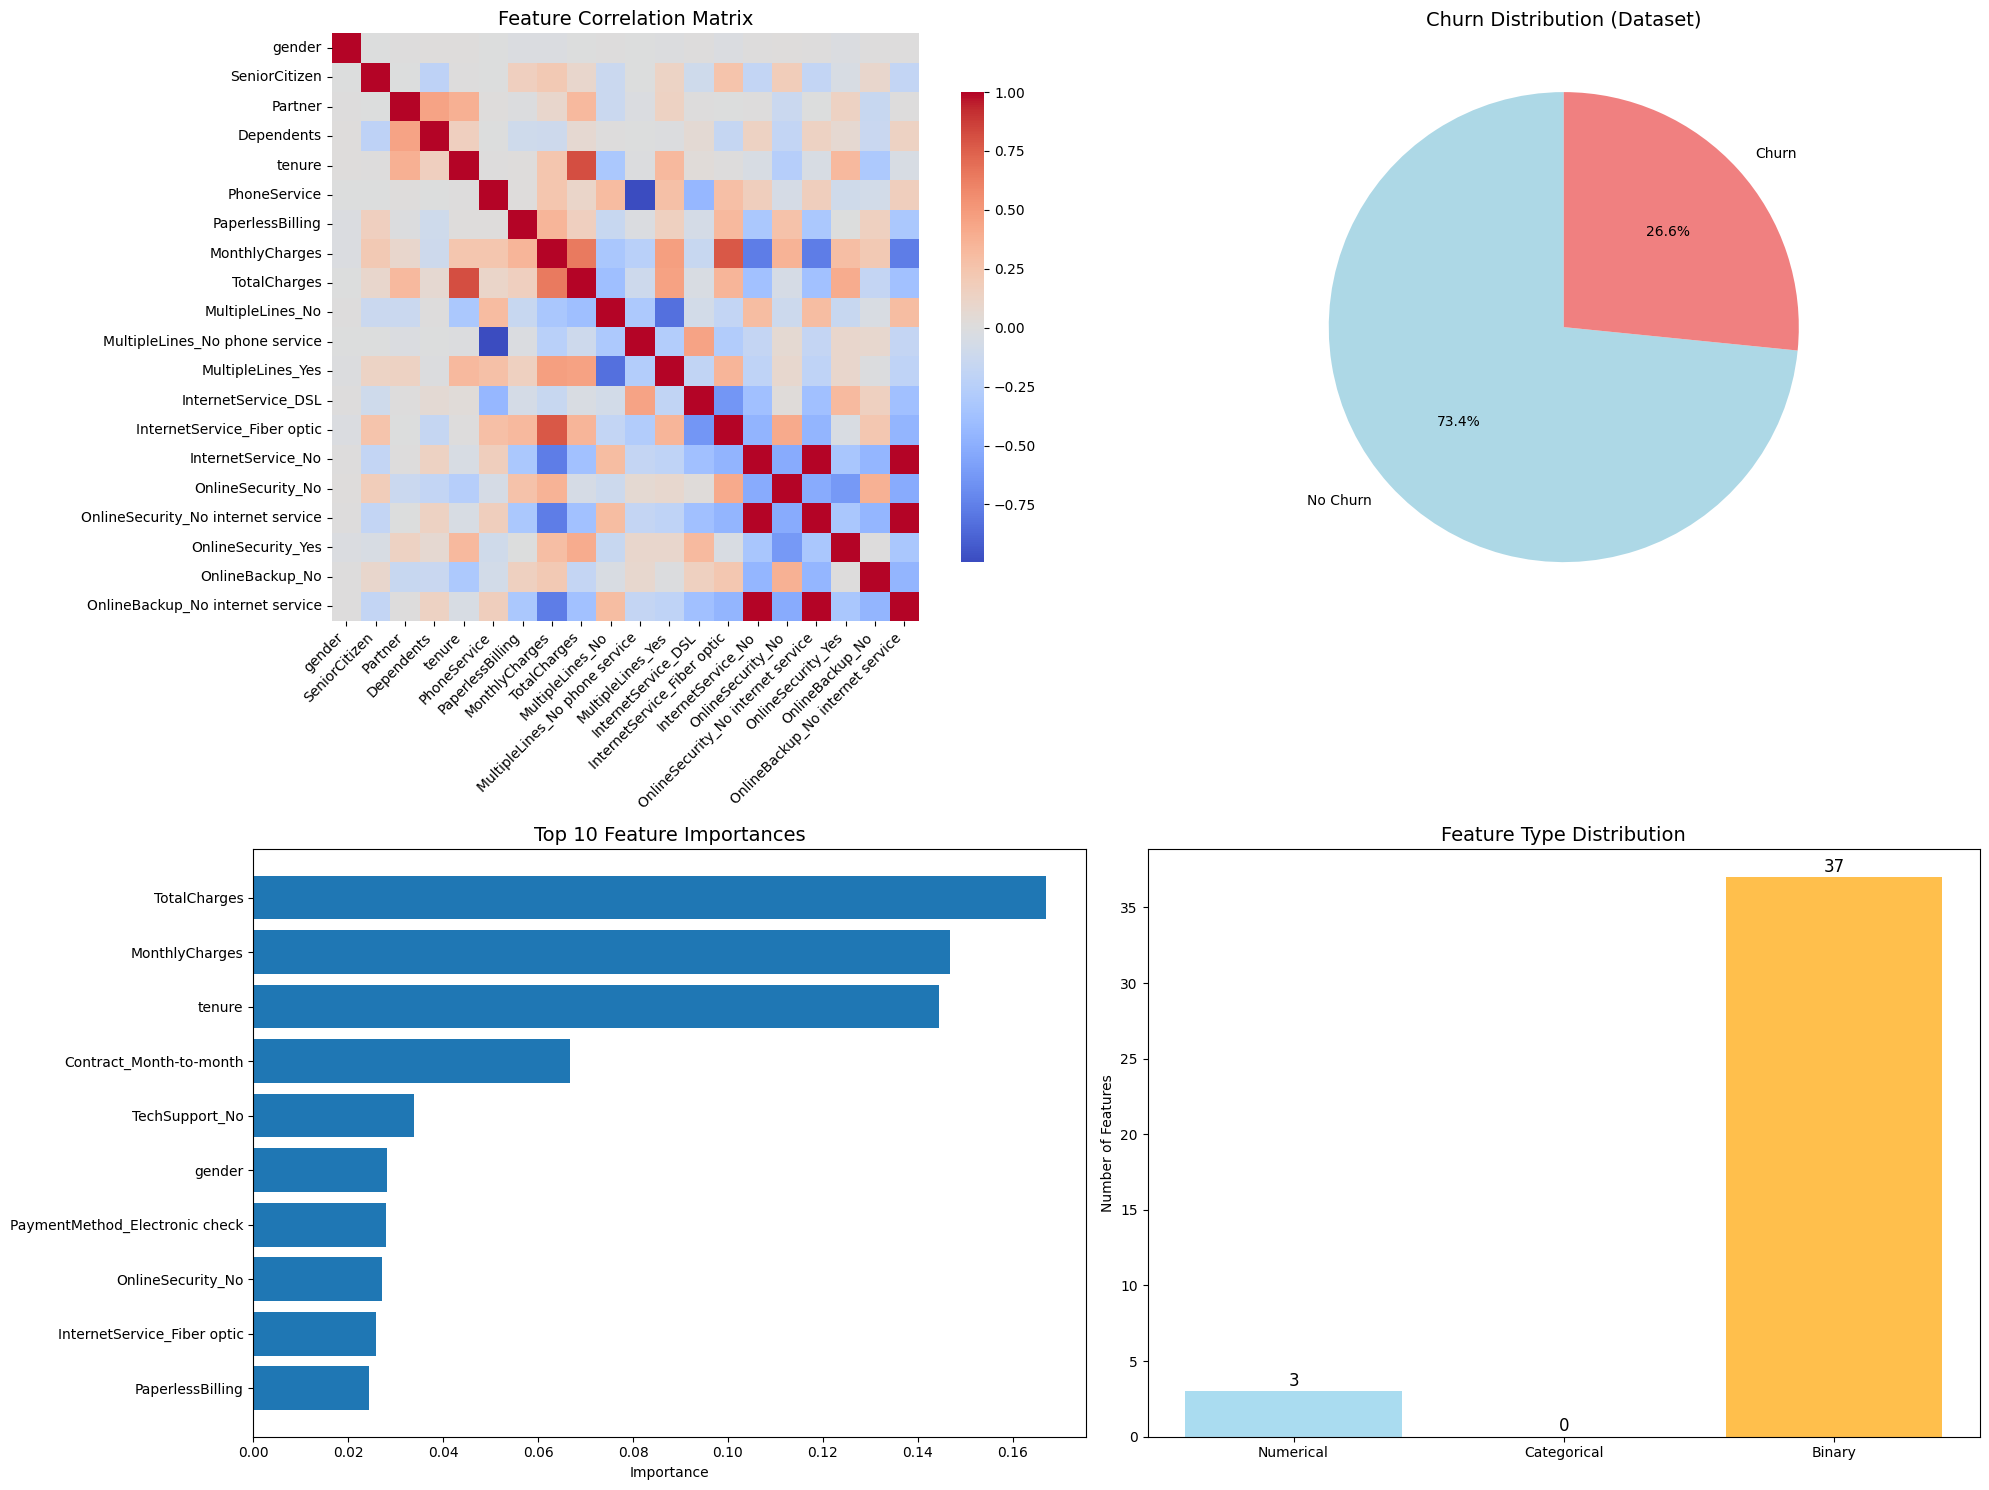

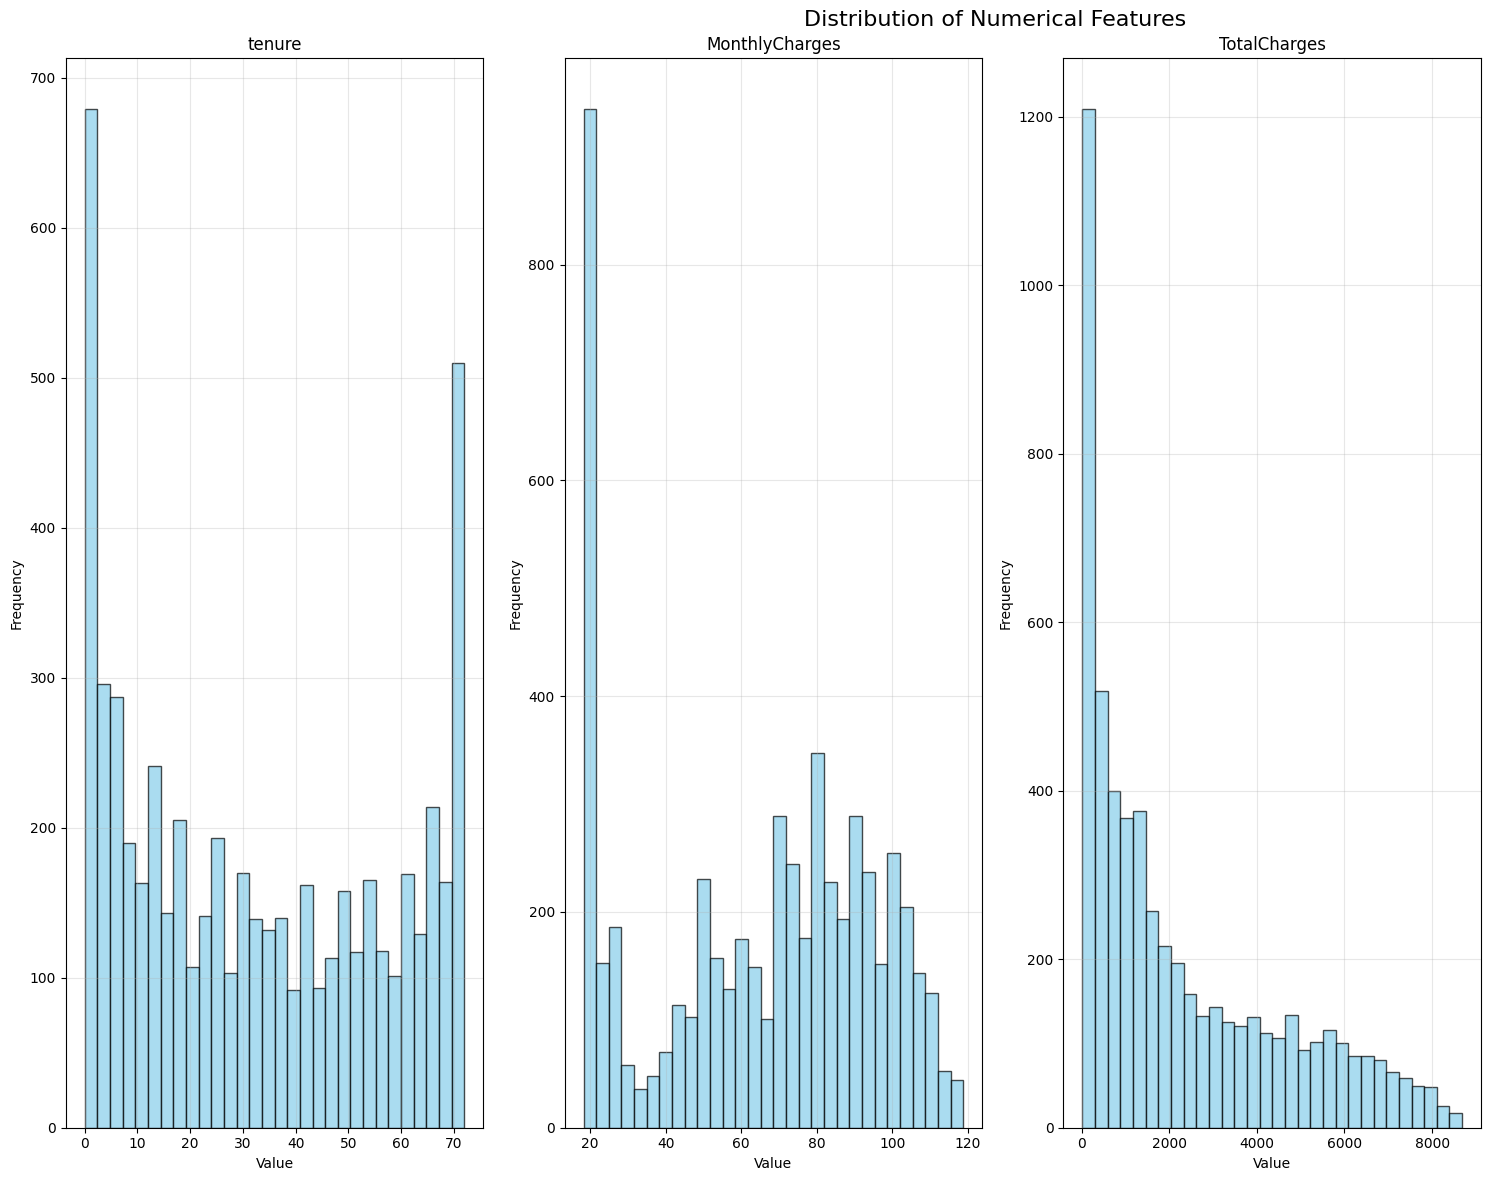

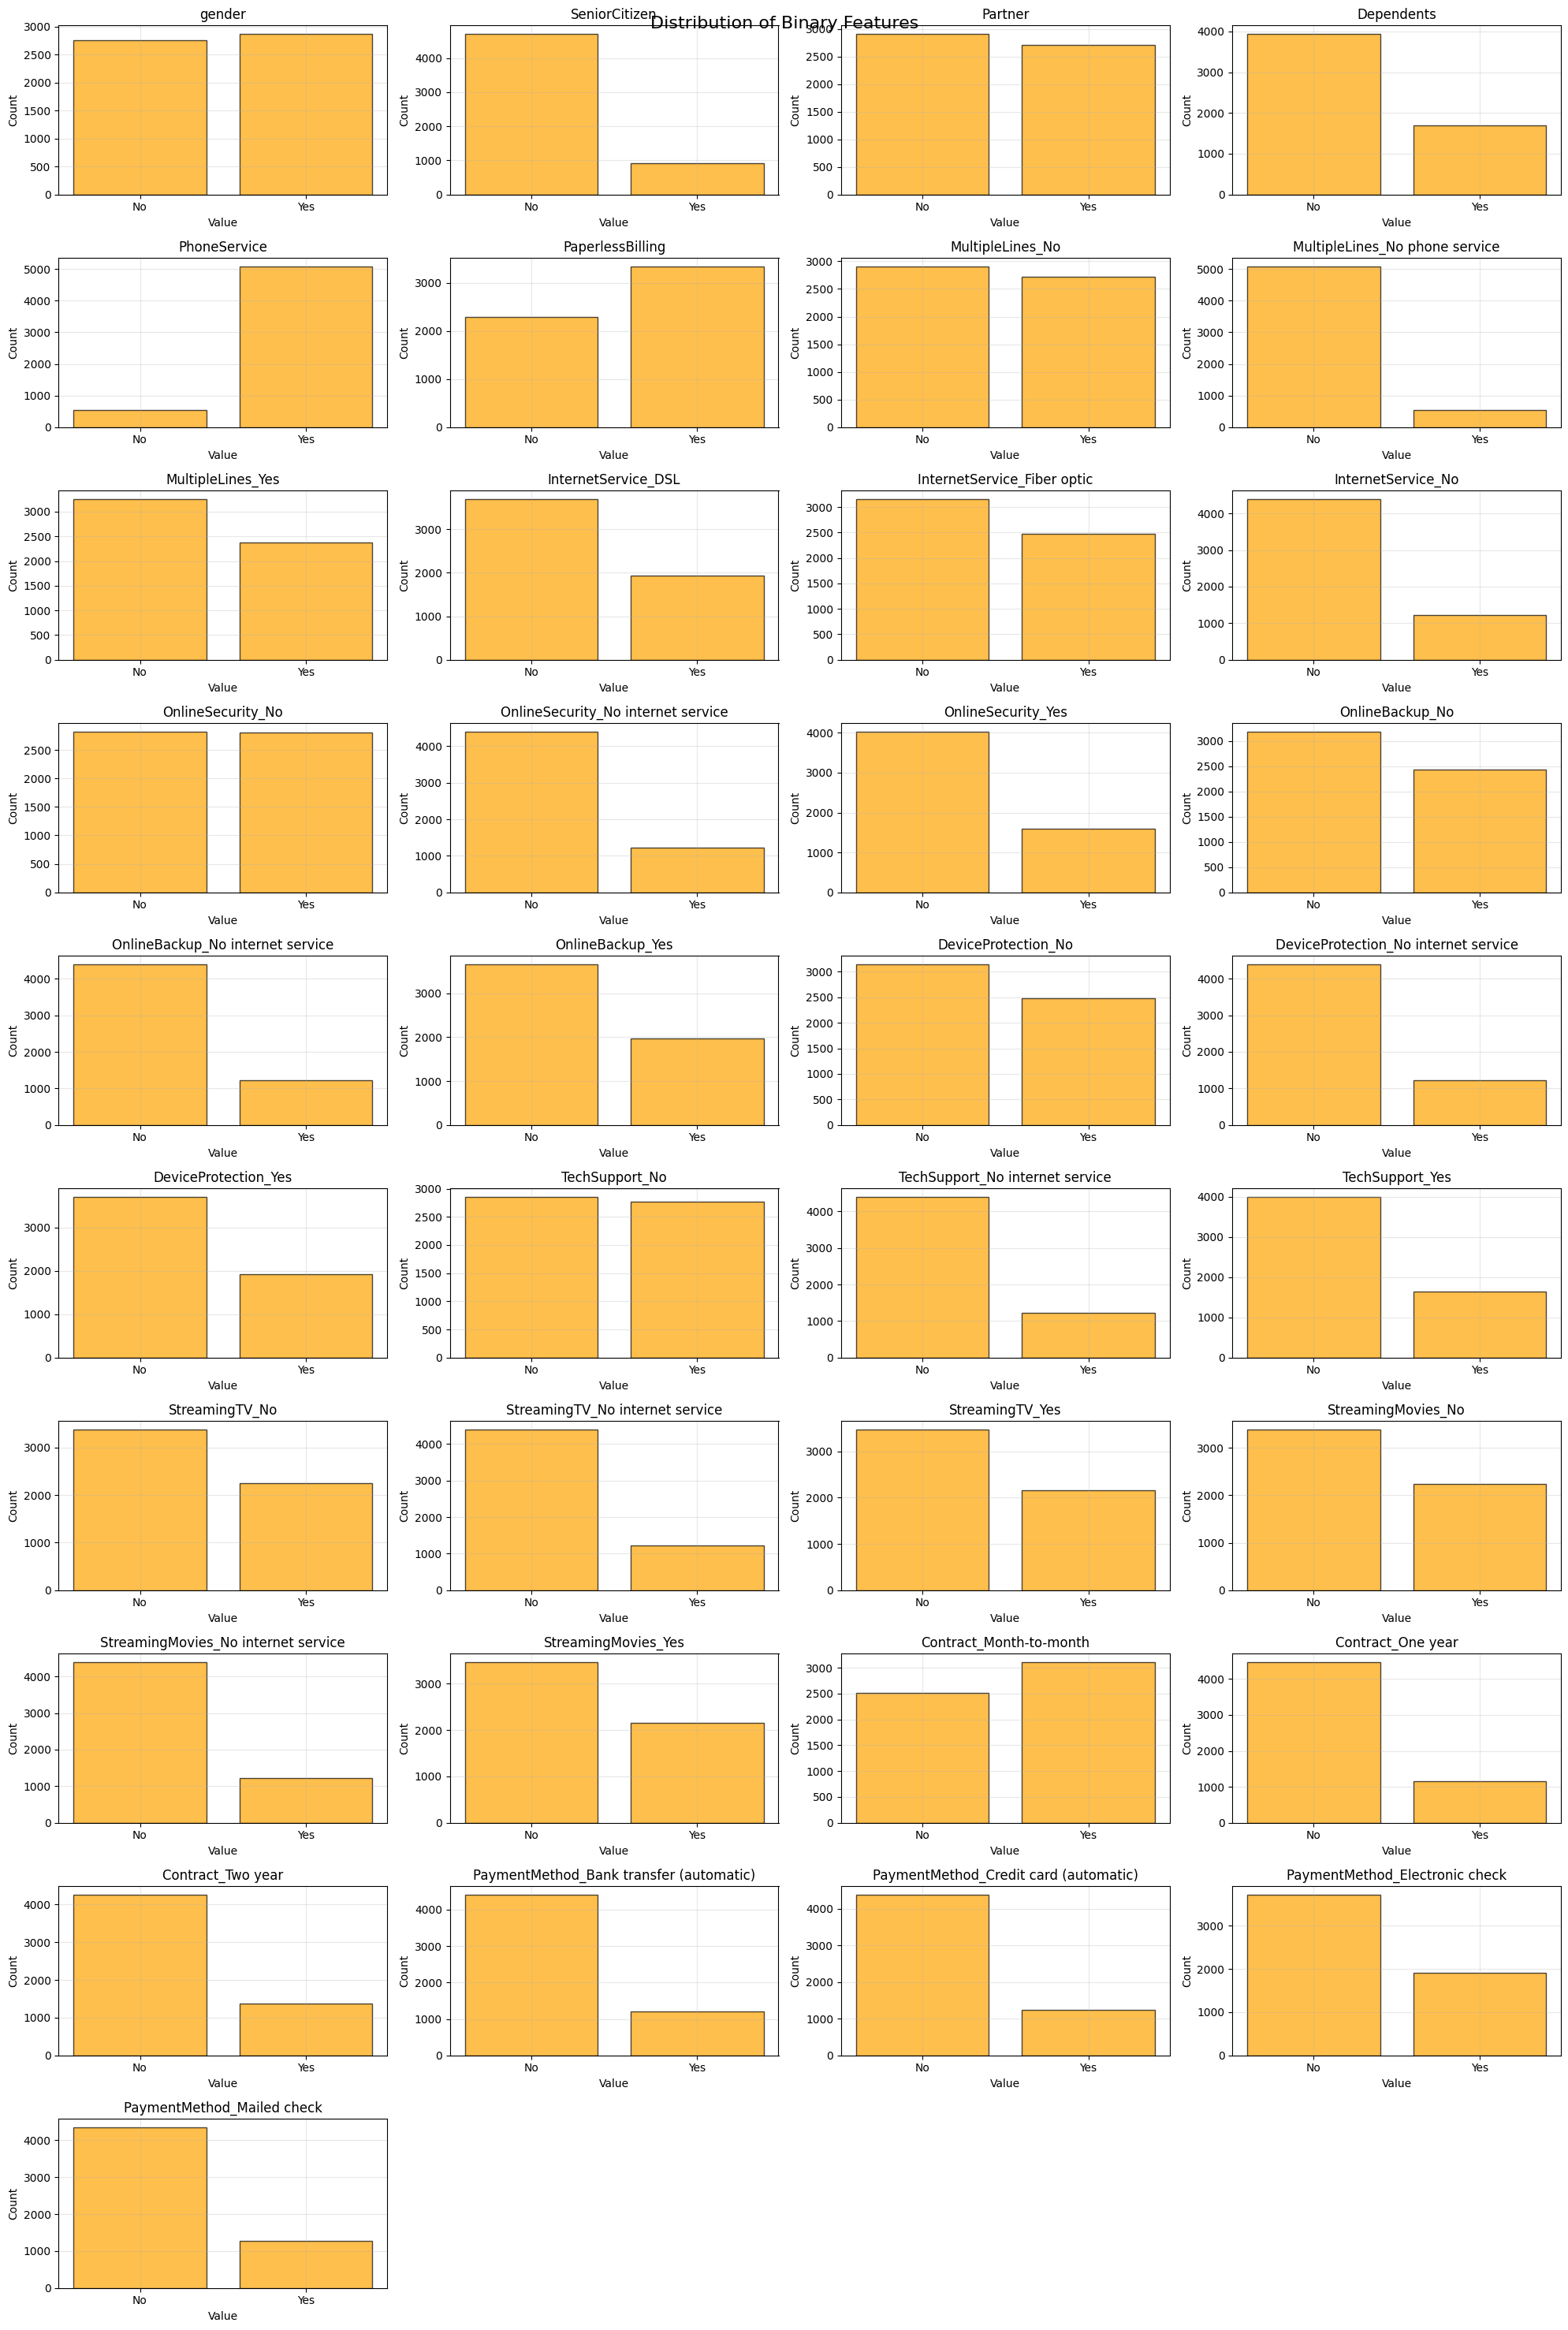


  SUMMARY STATISTICS  
Dataset Summary Statistics:
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  5634.000000    5634.000000  5634.000000  5634.000000  5634.000000   
mean      0.510295       0.162939     0.482073     0.299432    32.591997   
std       0.499938       0.369343     0.499723     0.458050    24.455505   
min       0.000000       0.000000     0.000000     0.000000     0.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    30.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  \
count   5634.000000       5634.000000     5634.000000   5634.000000   
mean       0.903798          0.593539       64.633724   2288.207172   
std        0.294894          0.491216       29.905

In [8]:
results = analyze_and_visualize_data(dataset_processed_df, churn_df, query_processed_df)

## Report

Write down what you tried in this section. Include your observations, hypothesis, things you are not sure about, ideas for experiments that could be worth trying. You are encouraged to use graphs/tables/pieces of code. You can create new code and text cells. Take a look [here](https://www.markdownguide.org/cheat-sheet/) to improve the quality of your report.

Things to consider in this section:
- Statistics
- Distributions
- Correlation matrix
- Principal Component Analysis

# Feature extraction

## Code

In [9]:
# Your code should start here
def scale_normalize_and_pca(dataset_processed_df: pd.DataFrame,
                           churn_df: pd.Series,
                           query_processed_df: pd.DataFrame,
                           scaling_method: str = 'standard',
                           pca_components: Union[int, float] = 0.95,
                           include_categorical: bool = False,
                           apply_log_transform: bool = True,
                           plot_results: bool = True,
                           figsize: Tuple[int, int] = (35, 20)) -> Dict:

    print("  SCALING, NORMALIZATION AND PCA ANALYSIS  ")
    query_features_df = query_processed_df.copy()

    # Ensure both dataframes have the same columns
    common_columns = dataset_processed_df.columns.intersection(query_features_df.columns)
    if len(common_columns) != len(dataset_processed_df.columns):
        print(f"Warning: Column mismatch detected. Using {len(common_columns)} common columns.")
        dataset_df = dataset_processed_df[common_columns].copy()
        query_df = query_features_df[common_columns].copy()
    else:
        dataset_df = dataset_processed_df.copy()
        query_df = query_features_df.copy()

    print(f"Dataset shape: {dataset_df.shape}")
    print(f"Query shape: {query_df.shape}")

    # Identify feature types
    numerical_features = []
    categorical_binary_features = []

    for col in dataset_df.columns:
        unique_vals = dataset_df[col].unique()
        unique_count = len(unique_vals)

        # Consider features with more than 2 unique values as numerical
        # (assuming preprocessing has already handled categorical encoding)
        if unique_count > 2 and not all(val in [0, 1] for val in unique_vals):
            numerical_features.append(col)
        else:
            categorical_binary_features.append(col)

    print(f"\nFeature Classification:")
    print(f"- Numerical features ({len(numerical_features)}): {numerical_features[:5]}{'...' if len(numerical_features) > 5 else ''}")
    print(f"- Categorical/Binary features ({len(categorical_binary_features)}): {categorical_binary_features[:5]}{'...' if len(categorical_binary_features) > 5 else ''}")

    # Add logarithmic features alongside originals if requested
    log_feature_names = []
    if apply_log_transform and numerical_features:
        print(f"\n  ADDING LOG FEATURES  ")
        print(f"Adding log1p versions of {len(numerical_features)} numerical features")
        
        # Check for negative values before log transformation
        negative_values_found = False
        for col in numerical_features:
            if (dataset_df[col] < 0).any() or (query_df[col] < 0).any():
                print(f"Warning: Negative values found in {col}. Log transformation may not be appropriate.")
                negative_values_found = True
        
        if negative_values_found:
            print("Consider handling negative values before log transformation.")
        
        # Add log-transformed versions alongside originals
        for col in numerical_features:
            log_col_name = f"{col}_log"
            dataset_df[log_col_name] = np.log1p(dataset_df[col])
            query_df[log_col_name] = np.log1p(query_df[col])
            log_feature_names.append(log_col_name)
        
        print(f"Log features added: {log_feature_names[:5]}{'...' if len(log_feature_names) > 5 else ''}")
        print("Log transformation completed using log1p(x) = log(1 + x)")
        print(f"Dataset shape after adding log features: {dataset_df.shape}")
        print(f"Query shape after adding log features: {query_df.shape}")
        
        # Update numerical features list to include log features
        all_numerical_features = numerical_features + log_feature_names
        print(f"Total numerical features (original + log): {len(all_numerical_features)}")
    elif apply_log_transform and not numerical_features:
        print("\nNote: Log transformation requested but no numerical features found.")
        all_numerical_features = numerical_features
    else:
        all_numerical_features = numerical_features

    # Determine features to scale
    if include_categorical:
        features_to_scale = list(dataset_df.columns)
        print(f"\nScaling all {len(features_to_scale)} features (including categorical/binary)")
    else:
        features_to_scale = all_numerical_features
        print(f"\nScaling only {len(features_to_scale)} numerical features (including log features)")

    if not features_to_scale:
        raise ValueError("No features selected for scaling!")

    # Choose scaler based on method
    if scaling_method == 'standard':
        scaler = StandardScaler()
        print("Using StandardScaler (mean=0, std=1) - optimal for SVM")
    elif scaling_method == 'minmax':
        scaler = MinMaxScaler()
        print("Using MinMaxScaler (range 0-1) - good for SVM")
    elif scaling_method == 'robust':
        scaler = RobustScaler()
        print("Using RobustScaler (median-based) - robust to outliers")
    else:
        raise ValueError("scaling_method must be 'standard', 'minmax', or 'robust'")

    # Fit scaler on dataset and transform both dataset and query
    print("\n  SCALING DATA  ")

    # Scale selected features
    dataset_scaled_features = scaler.fit_transform(dataset_df[features_to_scale])
    query_scaled_features = scaler.transform(query_df[features_to_scale])

    # Create scaled dataframes
    dataset_scaled_df = pd.DataFrame(
        dataset_scaled_features,
        columns=features_to_scale,
        index=dataset_df.index
    )
    query_scaled_df = pd.DataFrame(
        query_scaled_features,
        columns=features_to_scale,
        index=query_df.index
    )

    # Add non-scaled features if not including categorical in scaling
    if not include_categorical and categorical_binary_features:
        for col in categorical_binary_features:
            dataset_scaled_df[col] = dataset_df[col]
            query_scaled_df[col] = query_df[col]

        # Reorder columns to match original order
        dataset_scaled_df = dataset_scaled_df[dataset_df.columns]
        query_scaled_df = query_scaled_df[query_df.columns]

    print(f"Scaling completed. Features scaled: {len(features_to_scale)}")
    print(f"Dataset scaled range: [{dataset_scaled_df.min().min():.3f}, {dataset_scaled_df.max().max():.3f}]")
    print(f"Query scaled range: [{query_scaled_df.min().min():.3f}, {query_scaled_df.max().max():.3f}]")

    # Principal Component Analysis
    print("\n  PRINCIPAL COMPONENT ANALYSIS  ")

    # Determine number of components
    if isinstance(pca_components, float):
        if not (0 < pca_components <= 1):
            raise ValueError("If pca_components is float, it must be between 0 and 1")
        n_components = pca_components
        print(f"PCA will retain {pca_components:.1%} of variance")
    else:
        n_components = min(pca_components, dataset_scaled_df.shape[1], dataset_scaled_df.shape[0])
        print(f"PCA will use {n_components} components")

    # Fit PCA on scaled dataset
    pca = PCA(n_components=n_components, random_state=42)
    dataset_pca = pca.fit_transform(dataset_scaled_df)
    query_pca = pca.transform(query_scaled_df)

    # Create PCA dataframes
    n_components_actual = pca.n_components_
    pca_columns = [f'PC{i+1}' for i in range(n_components_actual)]

    dataset_pca_df = pd.DataFrame(
        dataset_pca,
        columns=pca_columns,
        index=dataset_df.index
    )
    query_pca_df = pd.DataFrame(
        query_pca,
        columns=pca_columns,
        index=query_df.index
    )

    # Calculate explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    print(f"PCA Results:")
    print(f"- Original features: {dataset_scaled_df.shape[1]}")
    print(f"- PCA components: {n_components_actual}")
    print(f"- Variance explained: {cumulative_variance[-1]:.1%}")
    print(f"- Dimensionality reduction: {dataset_scaled_df.shape[1]} → {n_components_actual}")

    print(f"\nTop 10 Principal Components:")
    for i in range(min(10, n_components_actual)):
        print(f"  PC{i+1}: {explained_variance_ratio[i]:.1%} variance")

    # Feature importance in PCA
    feature_importance_pca = pd.DataFrame(
        pca.components_[:min(5, n_components_actual)].T,
        index=dataset_scaled_df.columns,
        columns=[f'PC{i+1}' for i in range(min(5, n_components_actual))]
    )

    print(f"\nTop features contributing to first 5 PCs:")
    for pc in feature_importance_pca.columns:
        top_features = feature_importance_pca[pc].abs().nlargest(3)
        feature_details = []
        for feat, val in top_features.items():
            if feat in log_feature_names:
                feature_details.append(f"{feat}({val:.2f})[LOG]")
            else:
                feature_details.append(f"{feat}({val:.2f})")
        print(f"  {pc}: {', '.join(feature_details)}")

    # Results dictionary
    results = {
        # Original data
        'dataset_original': dataset_processed_df.copy(),  # Keep truly original data
        'query_original': query_processed_df.copy(),
        'churn_dataset': churn_df,

        # Log-transformed data (if applied)
        'dataset_log_transformed': dataset_df if apply_log_transform else None,
        'query_log_transformed': query_df if apply_log_transform else None,

        # Scaled data
        'dataset_scaled': dataset_scaled_df,
        'query_scaled': query_scaled_df,

        # PCA data
        'dataset_pca': dataset_pca_df,
        'query_pca': query_pca_df,

        # Fitted transformers
        'scaler': scaler,
        'pca': pca,

        # Feature information
        'numerical_features': numerical_features,
        'log_features': log_feature_names,
        'all_numerical_features': all_numerical_features,
        'categorical_binary_features': categorical_binary_features,
        'features_scaled': features_to_scale,

        # PCA information
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance,
        'feature_importance_pca': feature_importance_pca,

        # Metadata
        'scaling_method': scaling_method,
        'include_categorical': include_categorical,
        'apply_log_transform': apply_log_transform,
        'n_components_actual': n_components_actual
    }

    # Visualization
    if plot_results:
        print("\n  GENERATING VISUALIZATIONS  ")

        # Create visualization plots
        fig = plt.figure(figsize=figsize)

        # Plot 1: Explained Variance
        plt.subplot(2, 3, 1)
        plt.plot(range(1, len(explained_variance_ratio) + 1),
                 explained_variance_ratio, 'bo-', alpha=0.7, label='Individual')
        plt.plot(range(1, len(cumulative_variance) + 1),
                 cumulative_variance, 'ro-', alpha=0.7, label='Cumulative')
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('PCA Explained Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: First two principal components scatter
        plt.subplot(2, 3, 2)
        if n_components_actual >= 2:
            scatter = plt.scatter(dataset_pca_df['PC1'], dataset_pca_df['PC2'],
                                c=churn_df, alpha=0.6, cmap='viridis')
            plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
            plt.title('Dataset: First Two Principal Components')
            plt.colorbar(scatter, label='Churn')
        else:
            plt.text(0.5, 0.5, 'Need at least 2\nPCA components',
                    ha='center', va='center', transform=plt.gca().transAxes)

        # Plot 3: Feature distribution comparison
        plt.subplot(2, 3, 3)
        if all_numerical_features and apply_log_transform:
            sample_feature = numerical_features[0]
            log_sample_feature = f"{sample_feature}_log"
            plt.hist(dataset_processed_df[sample_feature], alpha=0.5, label='Original', bins=30)
            plt.hist(dataset_df[log_sample_feature], alpha=0.5, label='Log version', bins=30)
            plt.hist(dataset_scaled_df[sample_feature], alpha=0.5, label='Scaled original', bins=30)
            plt.hist(dataset_scaled_df[log_sample_feature], alpha=0.5, label='Scaled log', bins=30)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(f'Original vs Log Features: {sample_feature}')
            plt.legend()
        elif all_numerical_features:
            sample_feature = all_numerical_features[0]
            plt.hist(dataset_processed_df[sample_feature], alpha=0.5, label='Original', bins=30)
            plt.hist(dataset_scaled_df[sample_feature], alpha=0.5, label='Scaled', bins=30)
            plt.xlabel('Value')
            plt.ylabel('Frequency')
            plt.title(f'Scaling Effect: {sample_feature}')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'No numerical\nfeatures found',
                    ha='center', va='center', transform=plt.gca().transAxes)

        # Plot 4: PCA component importance heatmap
        plt.subplot(2, 3, 4)
        if n_components_actual >= 2:
            # Show feature importance for first few components
            importance_to_plot = feature_importance_pca.iloc[:, :min(8, n_components_actual)]
            top_features = feature_importance_pca.abs().sum(axis=1).nlargest(15).index
            importance_subset = importance_to_plot.loc[top_features]

            sns.heatmap(importance_subset.T, annot=True, cmap='coolwarm', center=0,
                       fmt='.2f', cbar_kws={'shrink': 0.8})
            plt.title('Feature Importance in PCA Components')
            plt.xlabel('Features')
            plt.ylabel('Principal Components')
        else:
            plt.text(0.5, 0.5, 'PCA importance\nvisualization',
                    ha='center', va='center', transform=plt.gca().transAxes)

        # Plot 5: Dataset vs Query in PCA space
        plt.subplot(2, 3, 5)
        if n_components_actual >= 2:
            plt.scatter(dataset_pca_df['PC1'], dataset_pca_df['PC2'],
                       alpha=0.6, label='Dataset', s=20)
            plt.scatter(query_pca_df['PC1'], query_pca_df['PC2'],
                       alpha=0.6, label='Query', s=20)
            plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.1%} variance)')
            plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.1%} variance)')
            plt.title('Dataset vs Query in PCA Space')
            plt.legend()
        else:
            plt.text(0.5, 0.5, 'Need at least 2\nPCA components',
                    ha='center', va='center', transform=plt.gca().transAxes)

        # Plot 6: Original vs Log feature correlation
        plt.subplot(2, 3, 6)
        if apply_log_transform and numerical_features:
            sample_feature = numerical_features[0]
            log_sample_feature = f"{sample_feature}_log"
            plt.scatter(dataset_df[sample_feature], dataset_df[log_sample_feature], 
                       alpha=0.6, s=10)
            plt.xlabel(f'Original {sample_feature}')
            plt.ylabel(f'Log {sample_feature}')
            plt.title(f'Original vs Log Feature Relationship')
            plt.grid(True, alpha=0.3)
            
            # Add correlation coefficient
            corr = np.corrcoef(dataset_df[sample_feature], dataset_df[log_sample_feature])[0,1]
            plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                    transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            plt.text(0.5, 0.5, 'Log features\nnot added',
                    ha='center', va='center', transform=plt.gca().transAxes)

        # plt.tight_layout()
        plt.show()

    print("\n  SCALING AND PCA COMPLETE  ")
    if apply_log_transform and numerical_features:
        print(f"✓ Log features added alongside originals: {len(numerical_features)} → {len(all_numerical_features)} numerical features")
    print(f"✓ Data scaled using {scaling_method} scaling")
    print(f"✓ PCA applied: {dataset_df.shape[1]} → {n_components_actual} dimensions")
    print(f"✓ Variance retained: {cumulative_variance[-1]:.1%}")
    print(f"✓ Data ready for SVM modeling")

    return results
# Your code should end here

  SCALING, NORMALIZATION AND PCA ANALYSIS  
Dataset shape: (5634, 40)
Query shape: (1409, 40)

Feature Classification:
- Numerical features (3): ['tenure', 'MonthlyCharges', 'TotalCharges']
- Categorical/Binary features (37): ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService']...

  ADDING LOG FEATURES  
Adding log1p versions of 3 numerical features
Log features added: ['tenure_log', 'MonthlyCharges_log', 'TotalCharges_log']
Log transformation completed using log1p(x) = log(1 + x)
Dataset shape after adding log features: (5634, 43)
Query shape after adding log features: (1409, 43)
Total numerical features (original + log): 6

Scaling only 6 numerical features (including log features)
Using StandardScaler (mean=0, std=1) - optimal for SVM

  SCALING DATA  
Scaling completed. Features scaled: 6
Dataset scaled range: [-2.653, 2.841]
Query scaled range: [-2.653, 2.787]

  PRINCIPAL COMPONENT ANALYSIS  
PCA will retain 95.0% of variance
PCA Results:
- Original features: 43


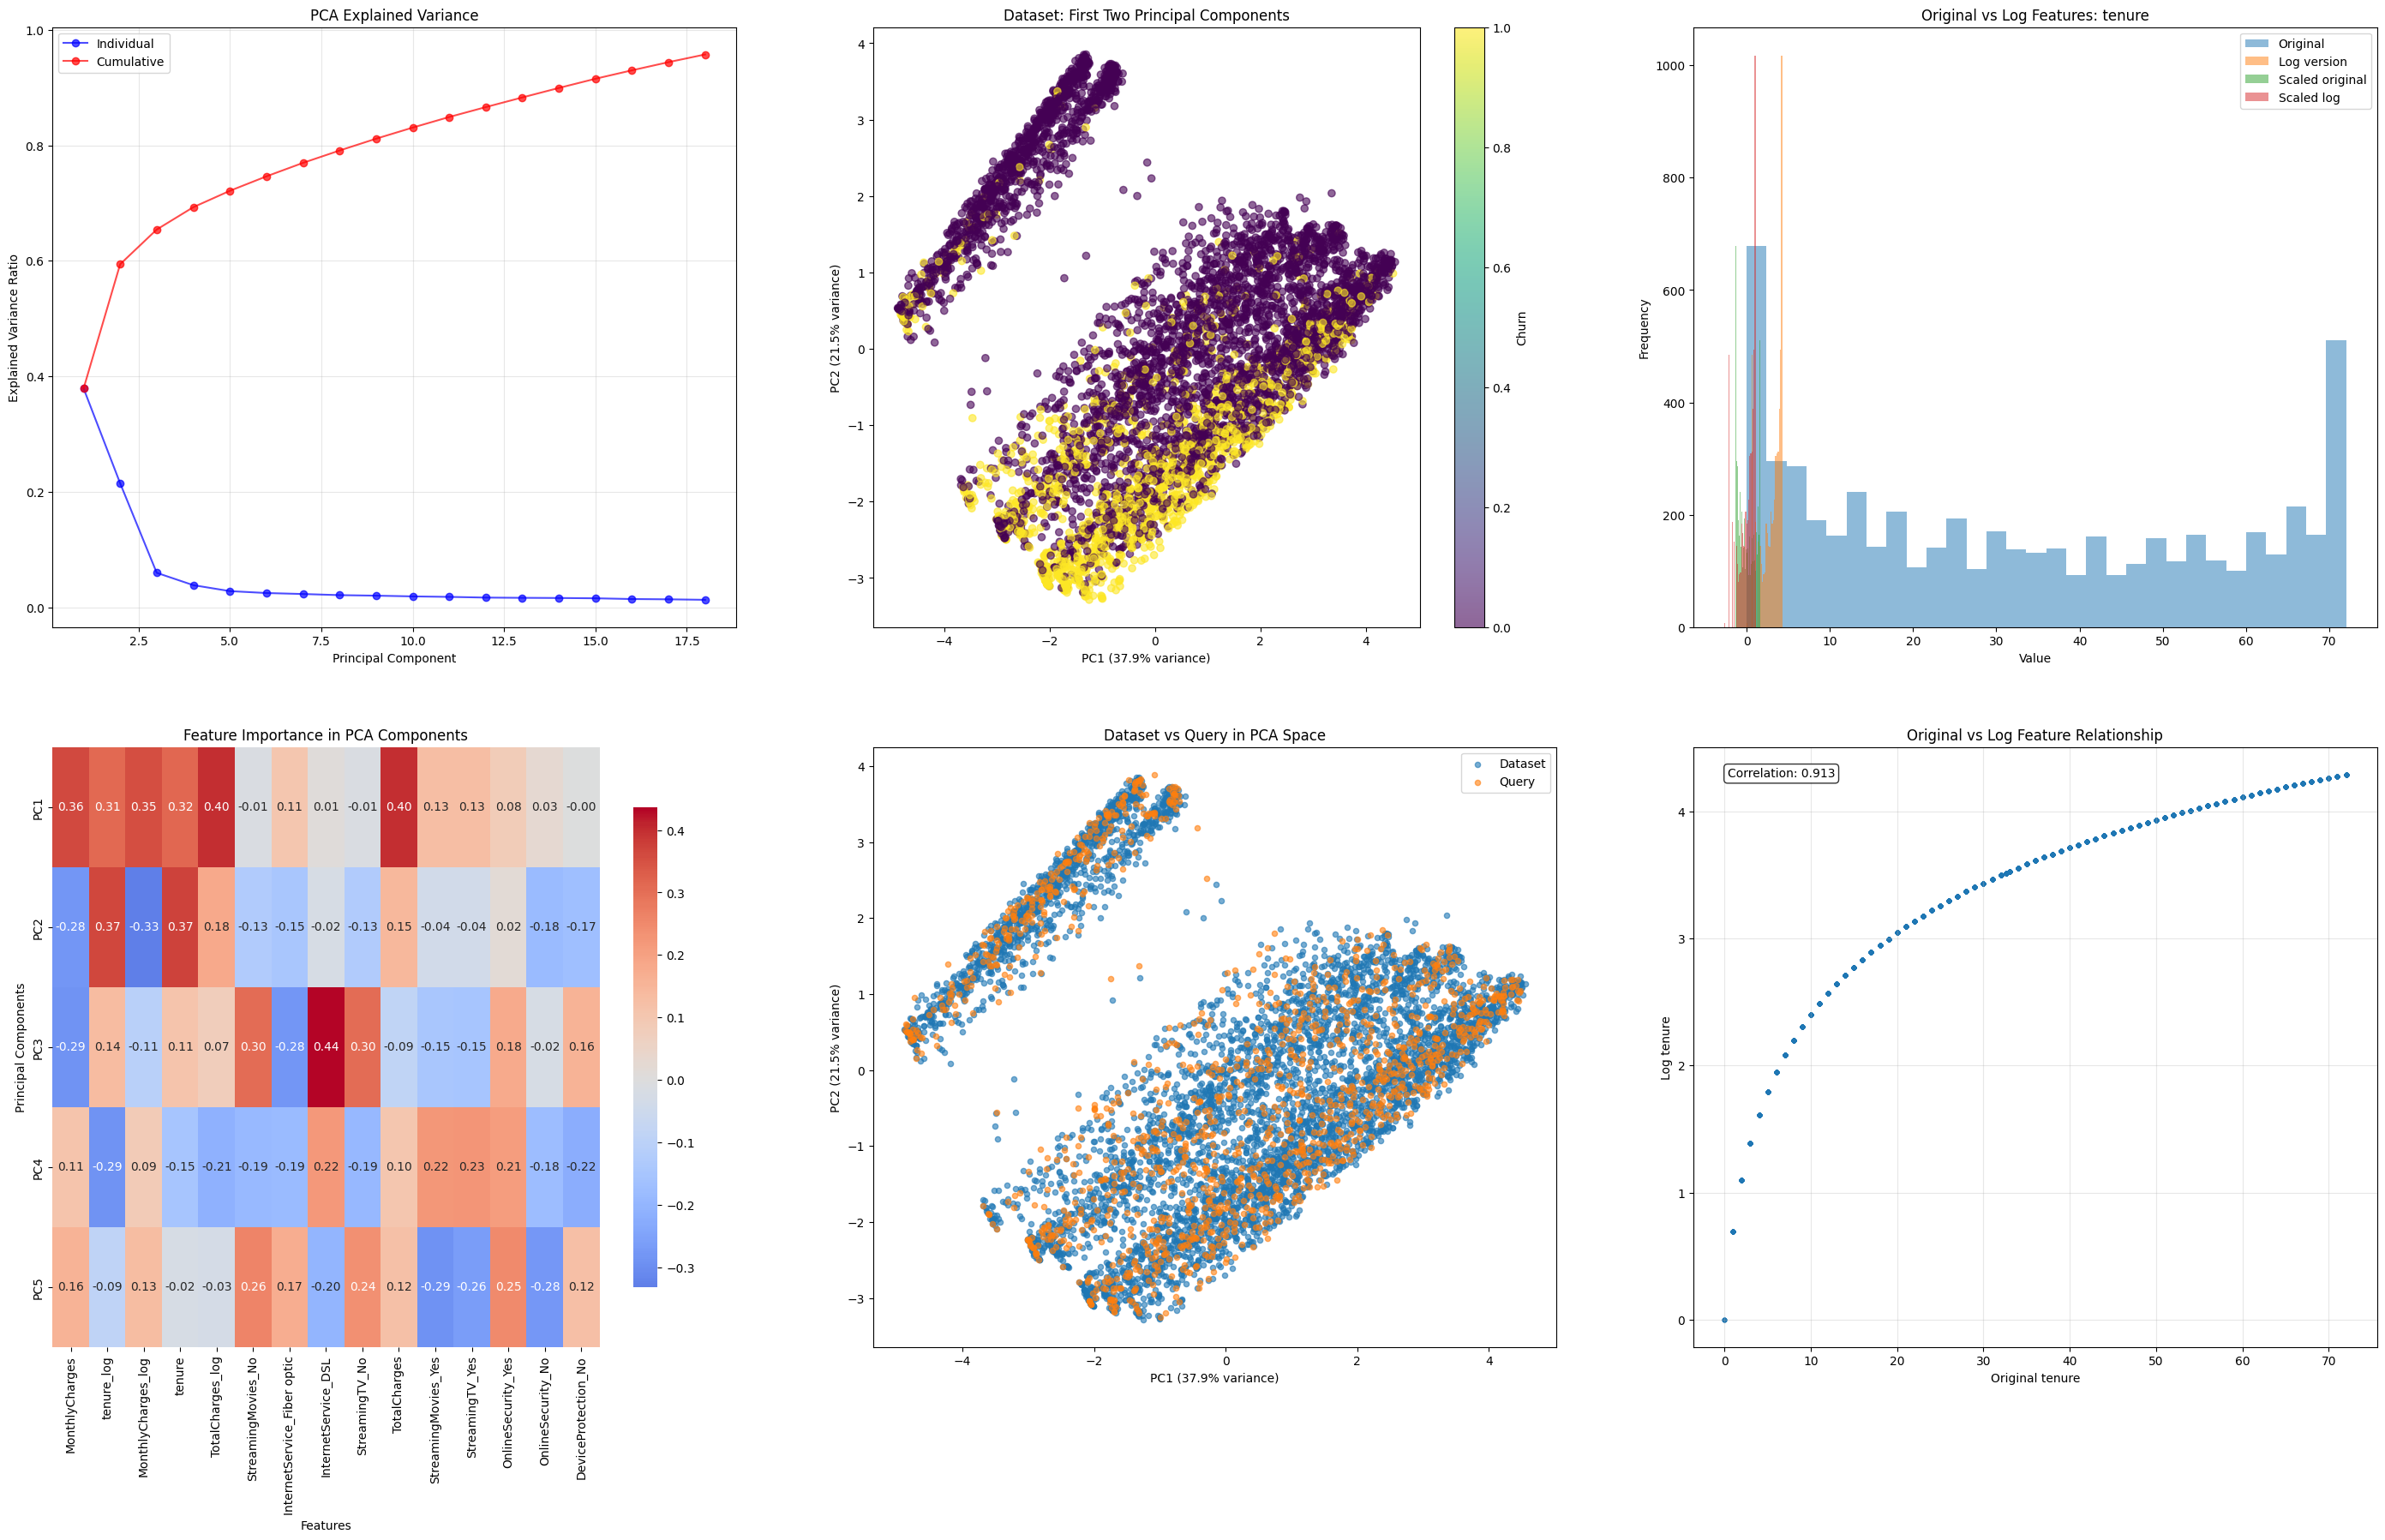


  SCALING AND PCA COMPLETE  
✓ Log features added alongside originals: 3 → 6 numerical features
✓ Data scaled using standard scaling
✓ PCA applied: 43 → 18 dimensions
✓ Variance retained: 95.7%
✓ Data ready for SVM modeling
  BASIC DATASET STATISTICS  
Dataset shape: (5634, 43)
Query data shape: (1409, 43)

Dataset missing values:
No missing values

Query data missing values:
No missing values

  CHURN DISTRIBUTION ANALYSIS  
Dataset Churn Distribution:
No Churn (0): 4136 (73.41%)
Churn (1): 1498 (26.59%)

  CORRELATION ANALYSIS  
Highly correlated feature pairs (|correlation| > 0.7):
  tenure - TotalCharges: 0.820
  tenure - tenure_log: 0.913
  tenure - TotalCharges_log: 0.827
  PhoneService - MultipleLines_No phone service: -0.995
  MonthlyCharges - InternetService_Fiber optic: 0.778
  MonthlyCharges - InternetService_No: -0.763
  MonthlyCharges - OnlineSecurity_No internet service: -0.762
  MonthlyCharges - OnlineBackup_No internet service: -0.762
  MonthlyCharges - DeviceProtectio

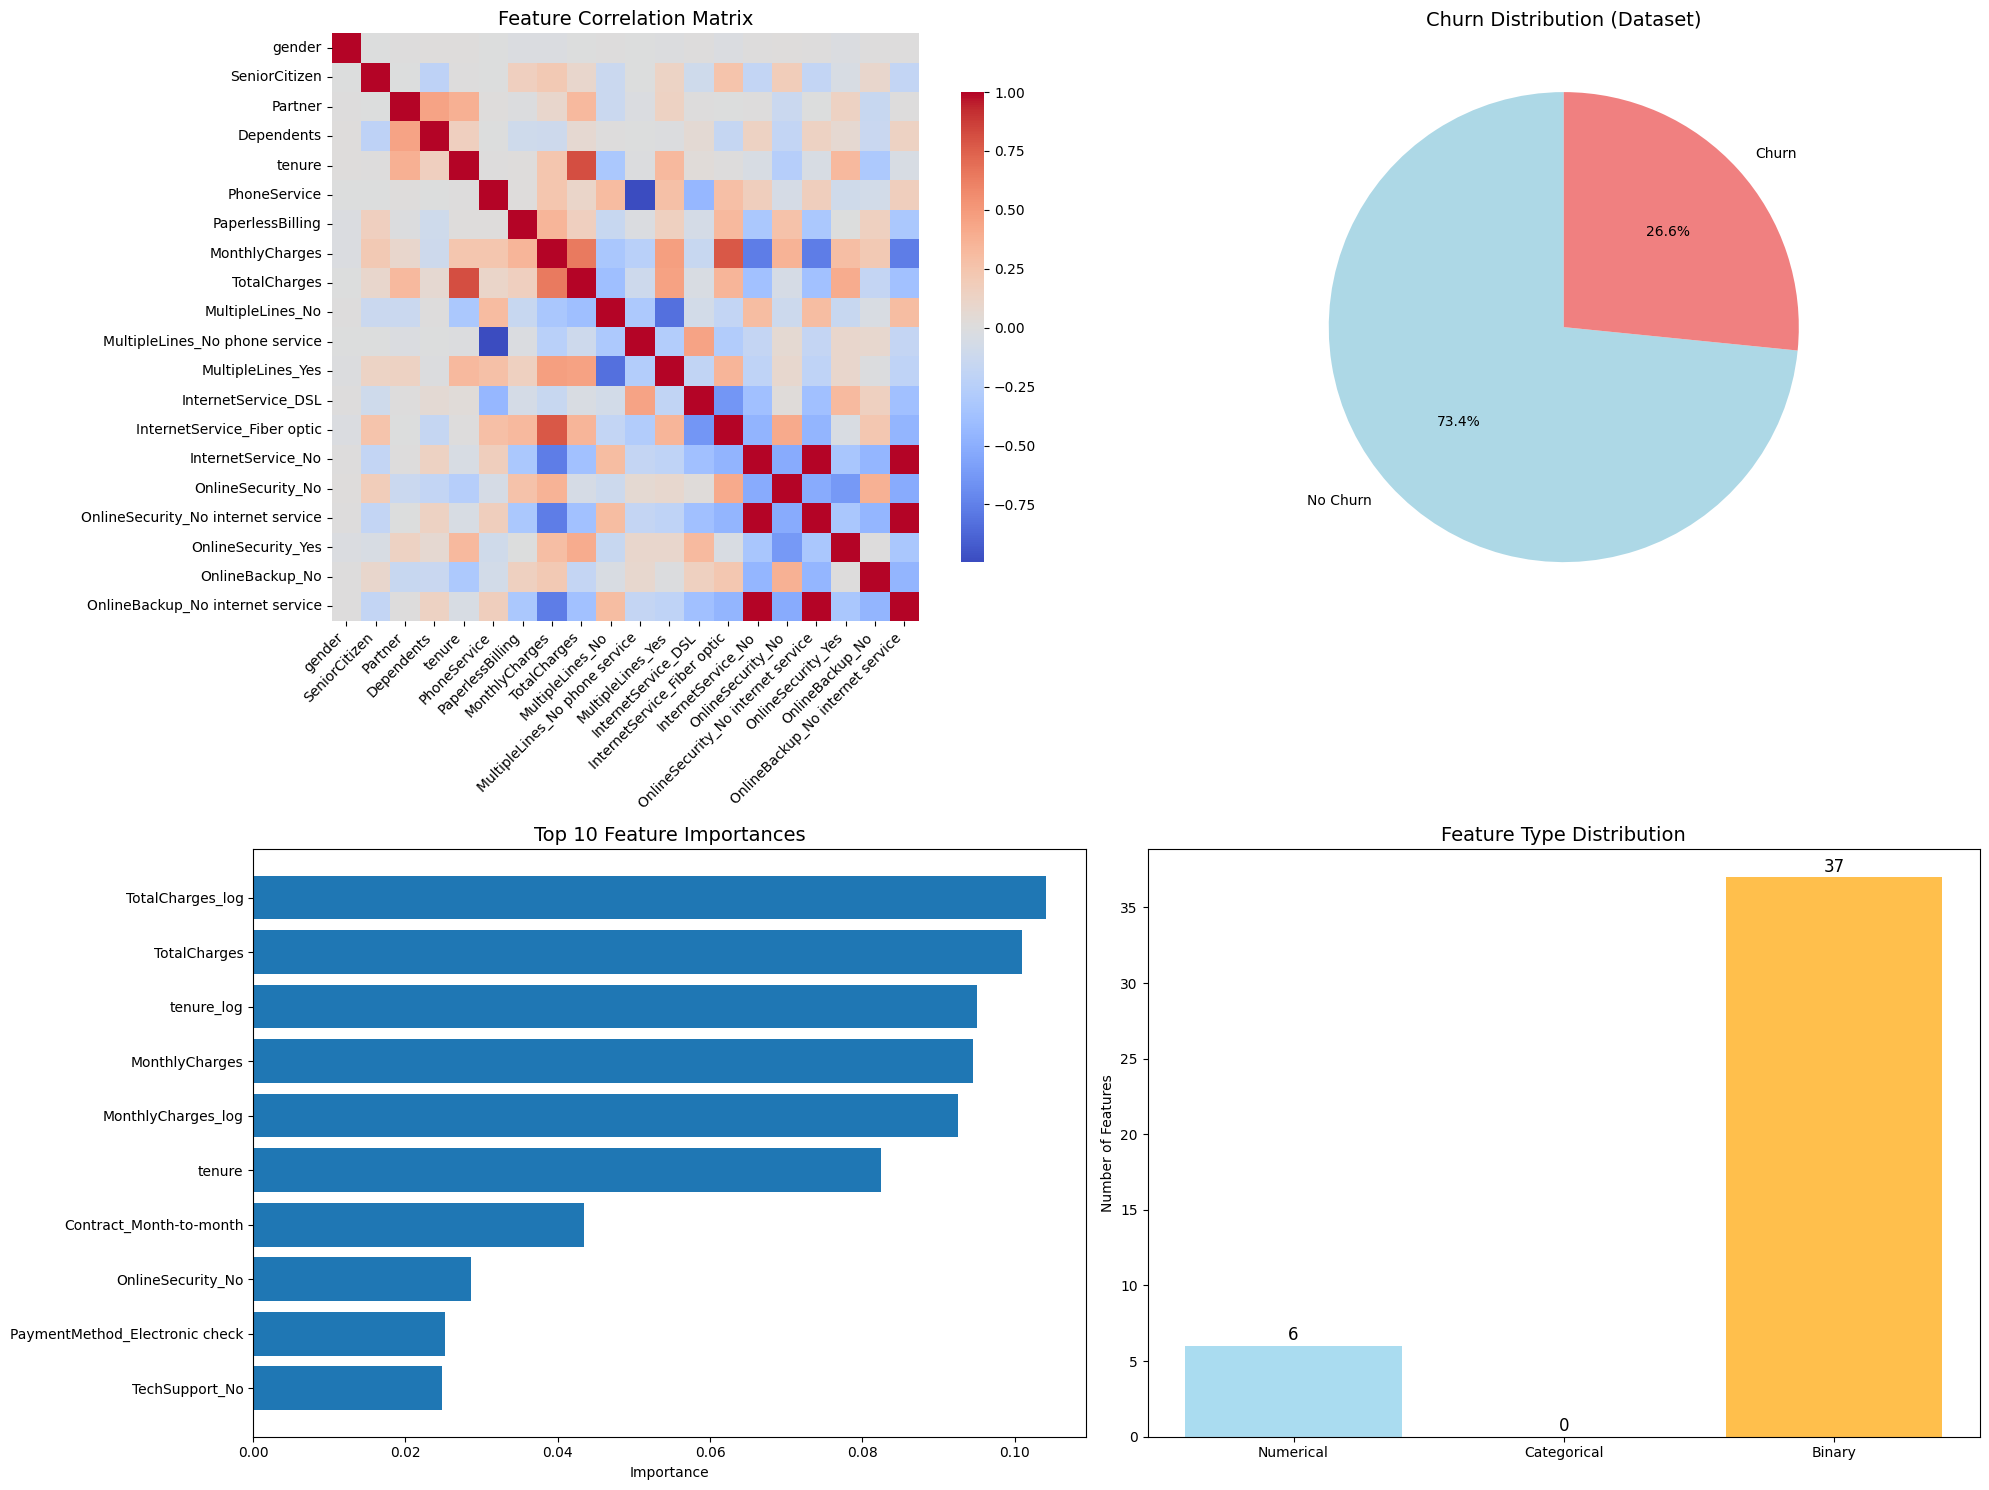

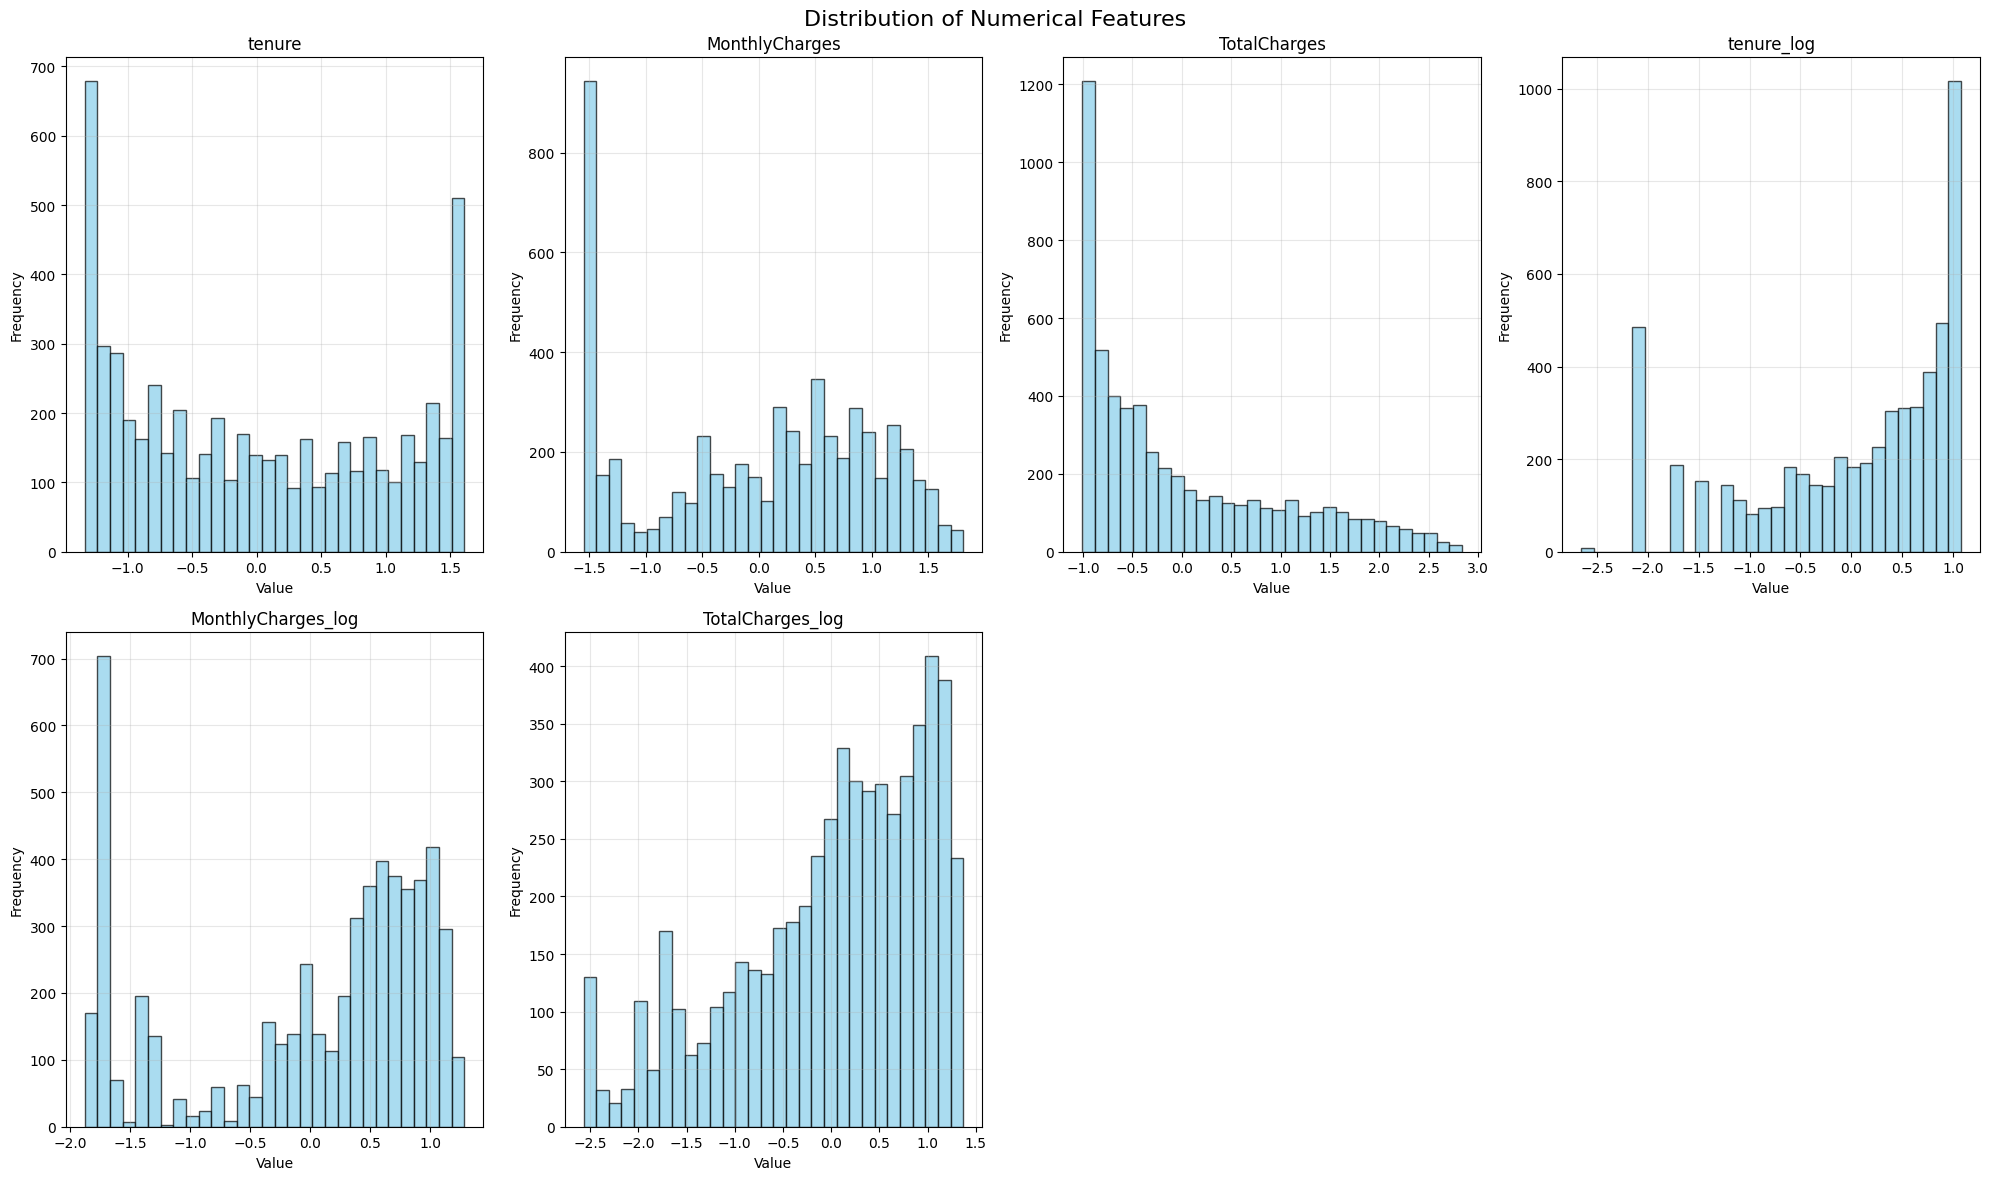

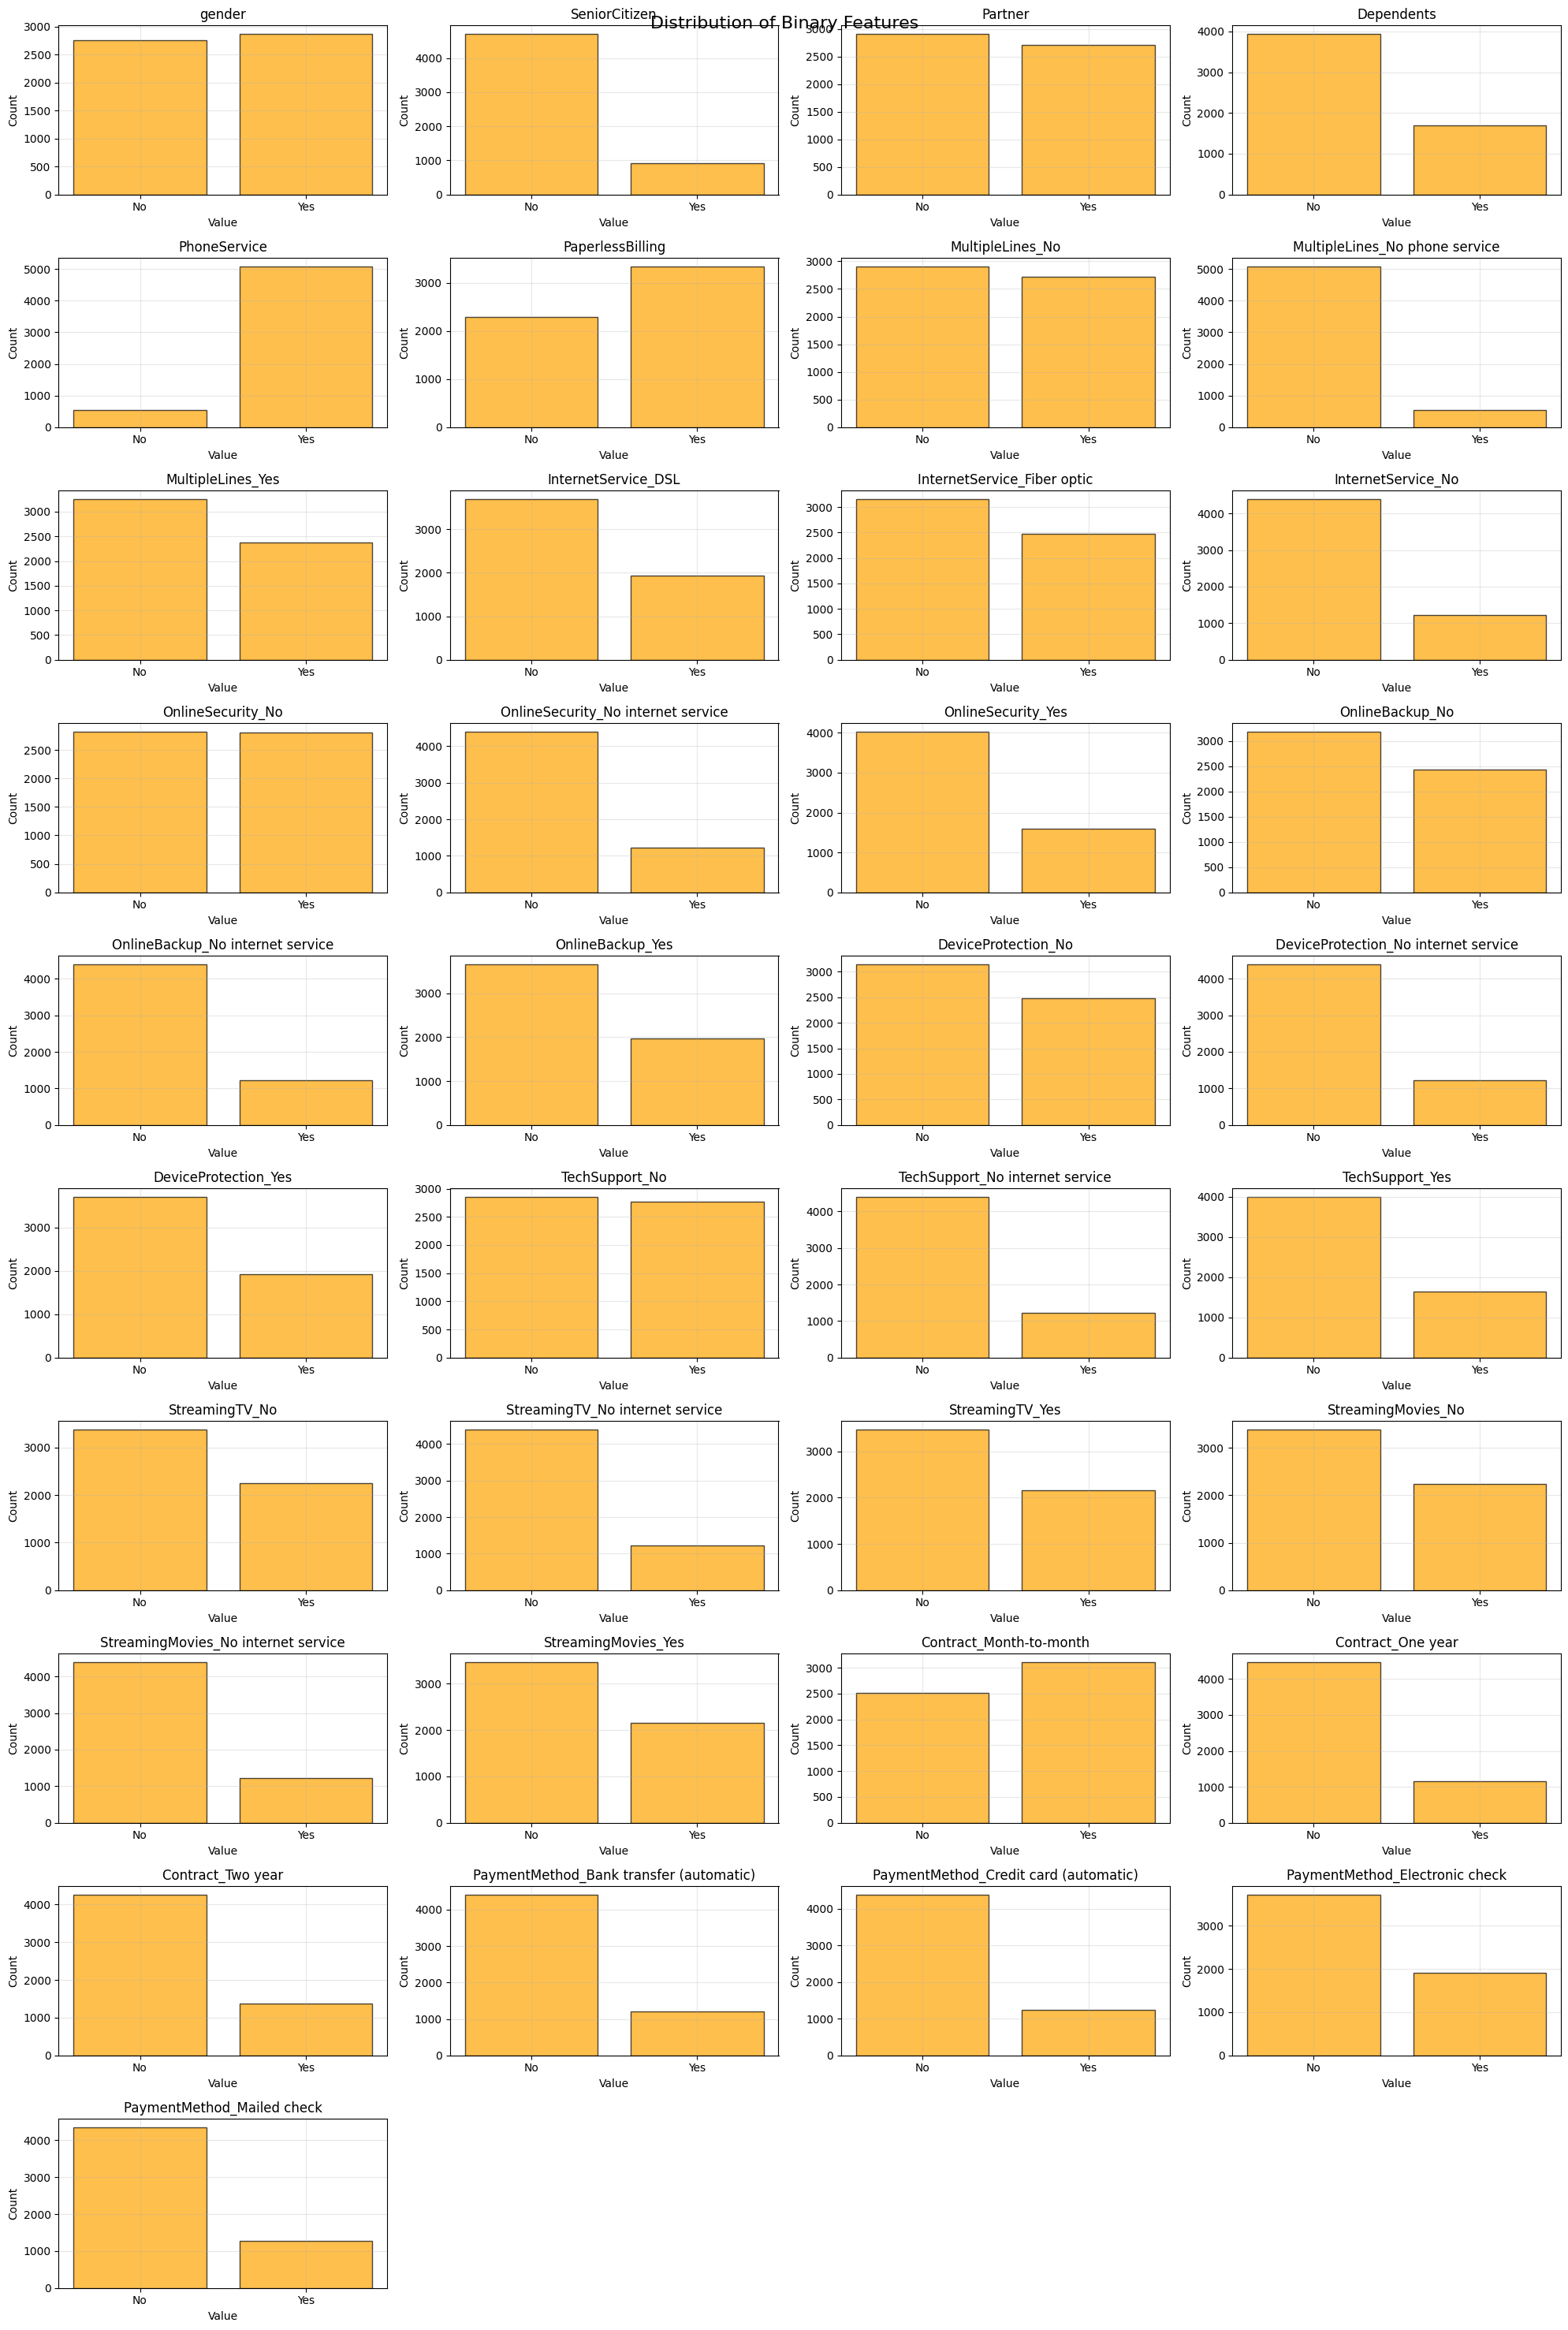


  SUMMARY STATISTICS  
Dataset Summary Statistics:
            gender  SeniorCitizen      Partner   Dependents        tenure  \
count  5634.000000    5634.000000  5634.000000  5634.000000  5.634000e+03   
mean      0.510295       0.162939     0.482073     0.299432 -1.179193e-16   
std       0.499938       0.369343     0.499723     0.458050  1.000089e+00   
min       0.000000       0.000000     0.000000     0.000000 -1.332824e+00   
25%       0.000000       0.000000     0.000000     0.000000 -9.647763e-01   
50%       1.000000       0.000000     0.000000     0.000000 -1.059977e-01   
75%       1.000000       0.000000     1.000000     1.000000  9.163577e-01   
max       1.000000       1.000000     1.000000     1.000000  1.611559e+00   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  \
count   5634.000000       5634.000000    5.634000e+03  5.634000e+03   
mean       0.903798          0.593539    3.316875e-16  1.399898e-16   
std        0.294894          0.491216    

In [10]:
results = scale_normalize_and_pca(
    dataset_processed_df,
    churn_df,
    query_processed_df,
    scaling_method='standard',
    pca_components=0.95,
    include_categorical=False,
    plot_results=True
)

analyze_and_visualize_data(
    results['dataset_scaled'],
    results['churn_dataset'],
    results['query_scaled'],
    figsize=(20, 15)
)

dataset_pca_df = results['dataset_pca']
query_pca_df = results['query_pca']

X_train, X_test, y_train, y_test = train_test_split(dataset_pca_df, churn_df, test_size=0.2, random_state=42, stratify=churn_df)

## Report

Write down what you tried in this section. Include your observations, hypothesis, things you are not sure about, ideas for experiments that could be worth trying. You are encouraged to use graphs/tables/pieces of code. You can create new code and text cells. Take a look [here](https://www.markdownguide.org/cheat-sheet/) to improve the quality of your report.

Things to consider in this section:
- Normalization/Standardization
- Transformations
- Feature importance
- PCA

# Training

## Code

In [11]:
def run_svm_grid_search(X_train, y_train):
    # Define kernel-specific parameter grids
    param_grid = [
        # Linear kernel
        {
            'kernel': ['linear'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'class_weight': [None, 'balanced']
        },
        # Gaussian kernel
        {
            'kernel': ['rbf'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.01, 0.001],
            'class_weight': [None, 'balanced']
        },
        # Polynomial kernel
        {
            'kernel': ['poly'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'degree': [2, 3, 4, 5],
            'coef0': [0.0, 0.5, 1.0],
            'class_weight': [None, 'balanced']
        },
        # Sigmoid kernel
        {
            'kernel': ['sigmoid'],
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'gamma': ['scale', 'auto'],
            'coef0': [0.0, 0.5, 1.0],
            'class_weight': [None, 'balanced']
        }
    ]

    # Base model
    base_model = SVC(probability=True, verbose=0, random_state=42)

    # Cross-validation with stratification
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        scoring='roc_auc',
        cv=cv,
        verbose=3,
        n_jobs=-1,
        refit=True
    )

    grid_search.fit(X_train, y_train)
    print("\nBest parameters found:", grid_search.best_params_)
    print("Best cross-validated ROC-AUC:", grid_search.best_score_)
    return grid_search.best_estimator_

def train_best_svm_model(best_model, X_train, y_train):
    best_model.set_params(verbose=3)  # Ensure reproducibility
    best_model.fit(X_train, y_train)
    return best_model


In [12]:
best_svm = run_svm_grid_search(X_train, y_train)
trained_svm = train_best_svm_model(best_svm, X_train, y_train)

Fitting 5 folds for each of 420 candidates, totalling 2100 fits
[CV 2/5] END C=0.01, class_weight=None, kernel=linear;, score=0.842 total time=   1.0s
[CV 5/5] END C=0.001, class_weight=None, kernel=linear;, score=0.861 total time=   1.1s
[CV 5/5] END C=0.01, class_weight=None, kernel=linear;, score=0.860 total time=   1.0s
[CV 1/5] END C=0.01, class_weight=None, kernel=linear;, score=0.836 total time=   1.1s
[CV 3/5] END C=0.01, class_weight=None, kernel=linear;, score=0.837 total time=   1.1s
[CV 2/5] END C=0.001, class_weight=None, kernel=linear;, score=0.846 total time=   1.1s
[CV 1/5] END C=0.001, class_weight=None, kernel=linear;, score=0.829 total time=   1.4s
[CV 4/5] END C=0.01, class_weight=None, kernel=linear;, score=0.839 total time=   1.1s
[CV 4/5] END C=0.001, class_weight=None, kernel=linear;, score=0.833 total time=   1.3s
[CV 1/5] END C=0.01, class_weight=balanced, kernel=linear;, score=0.836 total time=   1.4s
[CV 3/5] END C=0.001, class_weight=None, kernel=linear;, s

## Report

Write down what you tried in this section. Include your observations, hypothesis, things you are not sure about, ideas for experiments that could be worth trying. You are encouraged to use graphs/tables/pieces of code. You can create new code and text cells. Take a look [here](https://www.markdownguide.org/cheat-sheet/) to improve the quality of your report.

Things to consider in this section:
- Model
- Hyperparameters

# Validation

## Code

In [13]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Scores for ROC AUC (need probabilities or decision function)
    if hasattr(model, "predict_proba"):
        y_train_scores = model.predict_proba(X_train)[:, 1]
        y_test_scores = model.predict_proba(X_test)[:, 1]
    else:
        y_train_scores = model.decision_function(X_train)
        y_test_scores = model.decision_function(X_test)

    # Train scores
    print(" Training set performance:")
    print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"  F1 score:  {f1_score(y_train, y_train_pred):.4f}")
    print(f"  ROC AUC:   {roc_auc_score(y_train, y_train_scores):.4f}\n")

    # Test scores
    print(" Test set performance:")
    print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"  F1 score:  {f1_score(y_test, y_test_pred):.4f}")
    print(f"  ROC AUC:   {roc_auc_score(y_test, y_test_scores):.4f}")

In [14]:
evaluate_model(trained_svm, X_train, y_train, X_test, y_test)

 Training set performance:
  Accuracy:  0.8021
  F1 score:  0.5703
  ROC AUC:   0.8460

 Test set performance:
  Accuracy:  0.8004
  F1 score:  0.5648
  ROC AUC:   0.8479


In [15]:
final_model = train_best_svm_model(best_svm, dataset_pca_df, churn_df)
print("\nFinal model trained on full dataset.\n")
print(f"Model parameters: {final_model.get_params()}")

[LibSVM].
*
optimization finished, #iter = 1407
obj = -21.024960, rho = 1.087173
nSV = 2149, nBSV = 2131
Total nSV = 2149
.
*
optimization finished, #iter = 1467
obj = -21.065449, rho = 1.096927
nSV = 2147, nBSV = 2131
Total nSV = 2147
.
*
optimization finished, #iter = 1440
obj = -20.797533, rho = 1.087265
nSV = 2124, nBSV = 2108
Total nSV = 2124
.
*
optimization finished, #iter = 1389
obj = -20.744747, rho = 1.057321
nSV = 2115, nBSV = 2104
Total nSV = 2115
.
*
optimization finished, #iter = 1409
obj = -20.873817, rho = 1.060638
nSV = 2128, nBSV = 2114
Total nSV = 2128
.
*
optimization finished, #iter = 1630
obj = -26.069754, rho = -1.083580
nSV = 2651, nBSV = 2636
Total nSV = 2651

Final model trained on full dataset.

Model parameters: {'C': 0.01, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, '

## Report

Write down what you tried in this section. Include your observations, hypothesis, things you are not sure about, ideas for experiments that could be worth trying. You are encouraged to use graphs/tables/pieces of code. You can create new code and text cells. Take a look [here](https://www.markdownguide.org/cheat-sheet/) to improve the quality of your report.

Things to consider in this section:
- Data splitting
- Metric
- Cross-validation

# Prediction saving

Take extra care and make sure to save the predictions as a *CSV* file with the *Score* and the *Churn* columns. Your file should match the following format from the next cells.

In [16]:
test_predictions = pd.DataFrame(
    dict(
        Score=final_model.predict_proba(query_pca_df)[:, 1],
        Label=final_model.predict(query_pca_df)
        )
    )

,Score,Label
0,0.033380,0
1,0.156609,0
2,0.099829,0
3,0.102957,0
4,0.065124,0


Label counts:
Label
0    1111
1     298
Name: count, dtype: int64

Total predictions: 1409


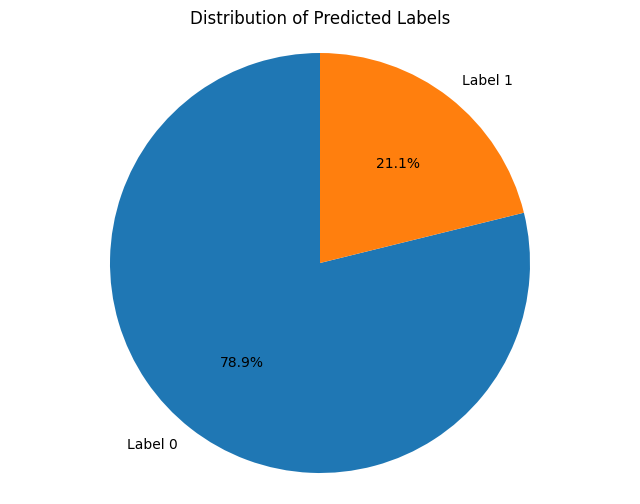

In [17]:
display(test_predictions.head(5))

# Count the labels
label_counts = test_predictions['Label'].value_counts().sort_index()
print("Label counts:")
print(label_counts)
print(f"\nTotal predictions: {len(test_predictions)}")

# Create pie chart
plt.figure(figsize=(8, 6))
plt.pie(label_counts.values,
         labels=[f'Label {int(label)}' for label in label_counts.index],
         autopct='%1.1f%%',
         startangle=90)
plt.title('Distribution of Predicted Labels')
plt.axis('equal')
plt.show()

In [18]:
test_predictions.to_csv('./test_predictions.csv')